## preparation

In [1]:
from google.colab import files

uploaded = files.upload()

Saving Noto_Sans_SC.zip to Noto_Sans_SC.zip


In [ ]:
!unzip Noto_Sans_SC.zip

Archive:  Noto_Sans_SC.zip
 extracting: OFL.txt                 
 extracting: README.txt              
 extracting: static/NotoSansSC-ExtraLight.ttf  
 extracting: static/NotoSansSC-Thin.ttf  
 extracting: static/NotoSansSC-Light.ttf  
 extracting: static/NotoSansSC-SemiBold.ttf  
 extracting: static/NotoSansSC-Medium.ttf  
 extracting: static/NotoSansSC-Regular.ttf  
 extracting: static/NotoSansSC-Bold.ttf  
 extracting: static/NotoSansSC-ExtraBold.ttf  
 extracting: static/NotoSansSC-Black.ttf  
 extracting: NotoSansSC-VariableFont_wght.ttf  


In [2]:
font_path = 'NotoSansSC-Regular.ttf'

In [3]:
!pip install git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import lucem_illud #just in case, regularly update your lucem_illud with the following code: pip install git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip
import requests #for http requests
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls

# comp-linguistics
import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

  Cloning https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-ppdk20tq
  Running command git clone --filter=blob:none --quiet https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-ppdk20tq
  Resolved https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to commit b17a265d3b8253424e5b38872457f7437909a65d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
from google.colab import drive
import os
import pandas as pd
import gzip
import json

In [ ]:
drive.mount('/content/drive',force_remount=True)

# Set the path to your dataset folder
folder_path = '/content/drive/My Drive/PeoplesDaily'

Mounted at /content/drive


In [ ]:

def calculate_word_probabilities(target_word, start_date, end_date, excluded_tokens):
    # Filter DataFrame for the period and texts containing the target word
    period_df = preprocessed_df[(preprocessed_df['date'] >= pd.to_datetime(start_date)) &
                                (preprocessed_df['date'] <= pd.to_datetime(end_date)) &
                                preprocessed_df['preprocessed_text'].astype(str).str.contains(target_word)]

    # Collect all words from these texts, excluding the target and other excluded words
    all_words = [word for text in period_df['preprocessed_text'].dropna() for word in text.split()
                 if word not in excluded_tokens and word != target_word]

    # Calculate word counts and total words for probability calculation
    word_counts = Counter(all_words)
    total_words = sum(word_counts.values())

    # Calculate probabilities
    word_probabilities = {word: (count / total_words) for word, count in word_counts.items()}

    # Sort words by highest probability and return the top 10
    return sorted(word_probabilities.items(), key=lambda x: x[1], reverse=True)[:10]


# KL divergence

In [ ]:
import pandas as pd
# Define time periods
period_1_start, period_1_end = "1985-01-01", "1989-06-01"
period_3_start, period_3_end = "1989-06-30", "2099-12-31"
keywords = {'经济','中国'}

# Check if all keywords are in the title tokens for each article
def contains_all_keywords(title_tokens, keywords):
    return all(keyword in title_tokens for keyword in keywords)

# Filter articles for the first period that contain all keywords
articles_period_1 = preprocessed_df[(preprocessed_df['date'] >= period_1_start) &
                                    (preprocessed_df['date'] <= period_1_end) &
                                    preprocessed_df['title_tokens'].apply(lambda x: contains_all_keywords(x, keywords))]

# Filter articles for the third period that contain all keywords
articles_period_3 = preprocessed_df[(preprocessed_df['date'] >= period_3_start) &
                                    (preprocessed_df['date'] <= period_3_end) &
                                    preprocessed_df['title_tokens'].apply(lambda x: contains_all_keywords(x, keywords))]

# Select 8 random articles from each period
random_articles_period_1 = articles_period_1.sample(n=8, random_state=1)
random_articles_period_3 = articles_period_3.sample(n=8, random_state=1)

# Assign names to articles in each period
random_articles_period_1['article_name'] = ['Article ' + str(i+1) + ' Before 1989' for i in range(random_articles_period_1.shape[0])]
random_articles_period_3['article_name'] = ['Article ' + str(i+1) + ' After 1989' for i in range(random_articles_period_3.shape[0])]

# Combine the selected articles from both periods into one DataFrame
selected_articles = pd.concat([random_articles_period_1, random_articles_period_3])



In [ ]:
import numpy as np
from collections import Counter
from scipy.stats import entropy
from scipy.stats import wasserstein_distance
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
import seaborn as sns
import matplotlib.pyplot as plt

# Assume selected_articles is your DataFrame with articles of interest
def calculate_word_frequencies(articles):
    """Calculate normalized word frequencies for a list of articles."""
    frequencies = []
    for article in articles:
        # Count word occurrences
        counts = Counter(article)
        total_count = sum(counts.values())
        # Normalize counts to get frequency
        frequencies.append({word: count / total_count for word, count in counts.items()})
    return frequencies

# Combine the selected articles from both periods into one DataFrame
selected_articles = pd.concat([random_articles_period_1, random_articles_period_3])

# Now, calculate word frequencies for these selected articles
word_frequencies = calculate_word_frequencies(selected_articles['title_tokens'])



In [ ]:
import numpy as np
from scipy.stats import entropy

def pairwise_kl_divergence(frequencies):
    """Manually calculate pairwise KL divergence between distributions."""
    # Make sure all distributions have the same set of keys
    all_words = set().union(*[freq.keys() for freq in frequencies])
    distributions = np.array([[freq.get(word, 0) for word in all_words] for freq in frequencies])

    # Add epsilon to distributions to avoid division by zero or log(0)
    epsilon = 1e-10
    distributions += epsilon

    # Calculate pairwise KL divergence
    num_distributions = len(distributions)
    kl_div = np.zeros((num_distributions, num_distributions))

    for i in range(num_distributions):
        for j in range(num_distributions):
            kl_div[i, j] = entropy(distributions[i], distributions[j])

    return kl_div

# Assuming word_frequencies is a list of dictionaries with the word frequencies for each article
kl_divergences = pairwise_kl_divergence(word_frequencies)


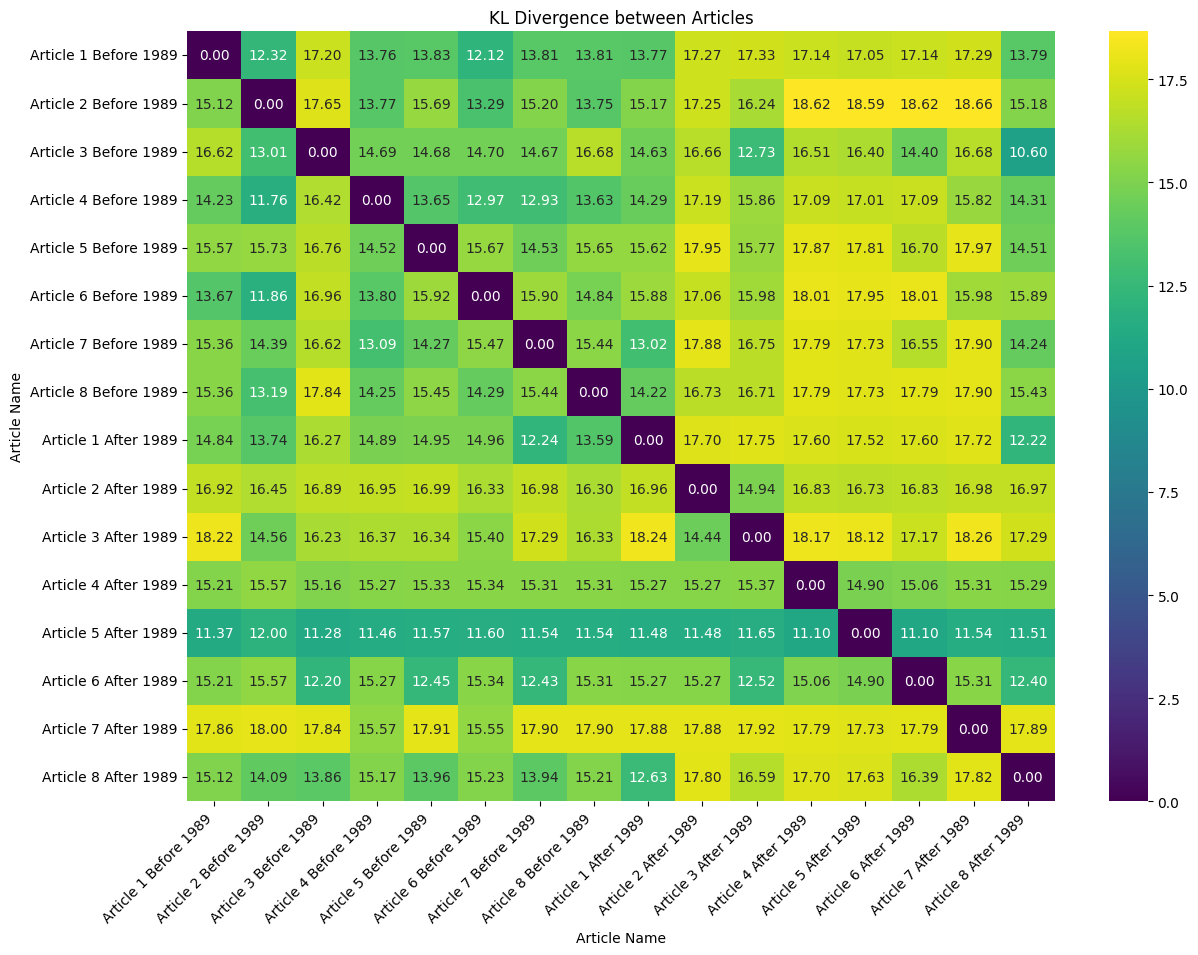

In [ ]:
article_names = selected_articles['article_name'].tolist()

# Visualizing KL divergence with a heatmap
plt.figure(figsize=(14, 10))  # Adjust the figure size as needed
sns.heatmap(kl_divergences, annot=True, fmt=".2f", cmap='viridis', xticklabels=article_names, yticklabels=article_names)
plt.title("KL Divergence between Articles")
plt.xticks(rotation=45, ha="right")  # Rotate x-labels for better readability
plt.xlabel("Article Name")
plt.ylabel("Article Name")
plt.show()

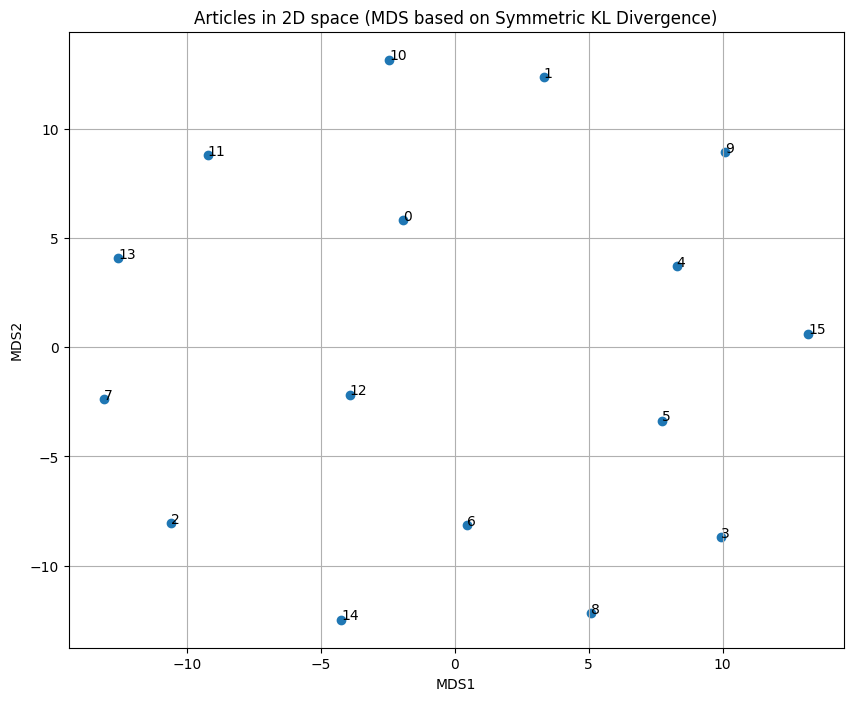

In [ ]:
def make_symmetric(matrix):
    """Make a matrix symmetric by averaging with its transpose."""
    return (matrix + matrix.T) / 2

# Making the KL divergence matrix symmetric
symmetric_kl_divergences = make_symmetric(kl_divergences)

# Now, we can apply MDS
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
articles_2d = mds.fit_transform(symmetric_kl_divergences)

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(articles_2d[:, 0], articles_2d[:, 1])
for i, txt in enumerate(range(len(articles_2d))):
    plt.annotate(txt, (articles_2d[i, 0], articles_2d[i, 1]))
plt.title("Articles in 2D space (MDS based on Symmetric KL Divergence)")
plt.xlabel("MDS1")
plt.ylabel("MDS2")
plt.grid(True)
plt.show()


#Week 3: Topic Modeling

In [6]:
drive.mount('/content/drive')

# Specify the path to your CSV file
file_path = '/content/drive/My Drive/preprocessed_df.csv'

# Load the CSV file into a DataFrame
preprocessed_df = pd.read_csv(file_path)

# Now you can work with the DataFrame `preprocessed_df`
print(preprocessed_df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
         date                             title  \
0  1985-01-01                和衷共济搞四化——一九八五年元旦献词   
1  1985-01-01                     一九八五年一月上旬天气展望   
2  1985-01-01                     血液换出稀释法可治疗脑血栓   
3  1985-01-01  玻利维亚紧张局势得到缓和  拒绝交权的前陆军司令奥尔维斯被迫投降   
4  1985-01-01                     北京假肢科研所主体工程奠基   

                                                text  \
0      和衷共济搞四化\n    ——一九八五年元旦献词\n    岁月之树又增添了一周新的...   
1      一九八五年一月上旬天气展望\n    据新华社北京12月31日电　中央气象台对198...   
2      血液换出稀释法可治疗脑血栓\n    山东省济宁市第二人民医院用血液换出稀释法治疗脑...   
3      玻利维亚紧张局势得到缓和\n    拒绝交权的前陆军司令奥尔维斯被迫投降\n    ...   
4      北京假肢科研所主体工程奠基\n    本报讯  民政部北京假肢科研主体工程12月31...   

                                   preprocessed_text  \
0          和衷共济 搞 四化 \n         一九八五年 元旦 献词 \n   ...   
1          一九八五年 一月 上旬 天气 展望 \n         新华社 北京 12...   
2          血液 换 出 稀释 法可 治疗 脑血栓 \n         山东省 济宁市...   
3  

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

text_data = preprocessed_df['preprocessed_text'].fillna("")  # Replace 'text_data' with the actual column name containing the text

# Initialize TfidfVectorizer without specifying stop_words since they are already removed
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, norm='l2')

# Fit the vectorizer and transform the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)

# Retrieve the vocabulary and feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Print the first 20 features and their corresponding indices in the vocabulary
print(list(zip(feature_names, range(len(feature_names))))[:20])


[('10', 0), ('100', 1), ('11', 2), ('12', 3), ('13', 4), ('14', 5), ('15', 6), ('16', 7), ('17', 8), ('18', 9), ('19', 10), ('1984', 11), ('1985', 12), ('1986', 13), ('20', 14), ('21', 15), ('25', 16), ('30', 17), ('40', 18), ('50', 19)]


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

preprocessed_df['date'] = pd.to_datetime(preprocessed_df['date'])

# Define time periods
periods = [
    ("1985-01-01", "1989-06-01"),
    ("1989-06-01", "1989-06-30"),
    ("1989-06-30", "1997-12-31")
]

# Number of clusters for K-means
num_clusters = 3

for start_date, end_date in periods:
    # Filter the DataFrame for the current period
    period_df = preprocessed_df[(preprocessed_df['date'] >= start_date) & (preprocessed_df['date'] <= end_date)]

    # Vectorize the preprocessed text
    count_vectorizer = CountVectorizer()
    X = count_vectorizer.fit_transform(period_df['preprocessed_text'].fillna("").tolist())

    # Perform K-means clustering
    km = KMeans(n_clusters=num_clusters, random_state=42)
    km.fit(X)

    # Get the feature names (terms) from the vectorizer
    terms = count_vectorizer.get_feature_names_out()

    # Get the order of centroids
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    print(f"Top terms per cluster for period {start_date} to {end_date}:")
    for i in range(num_clusters):
        print(f"Cluster {i}:")
        for ind in order_centroids[i, :10]:  # Get top 10 terms per cluster
            print(f" {terms[ind]}")
        print("\n")


Top terms per cluster for period 1985-01-01 to 1989-06-01:
Cluster 0:
 发展
 企业
 经济
 改革
 工作
 问题
 社会主义
 国家
 建设
 社会


Cluster 1:
 中国
 新华社
 记者
 问题
 工作
 日电
 进行
 国家
 发展
 北京


Cluster 2:
 发展
 经济
 问题
 中国
 工作
 企业
 改革
 国家
 同志
 进行


Top terms per cluster for period 1989-06-01 to 1989-06-30:
Cluster 0:
 中国
 北京
 日电
 问题
 新华社
 国家
 记者
 人民
 经济
 发展


Cluster 1:
 暴乱
 国务院
 党中央
 反革命
 工作
 人民
 平息
 坚决
 全国
 共产党员


Cluster 2:
 暴乱
 同志
 反革命
 工作
 学生
 人民
 部队
 社会主义
 戒严
 坚持


Top terms per cluster for period 1989-06-30 to 1997-12-31:
Cluster 0:
 发展
 中国
 经济
 企业
 工作
 问题
 建设
 国家
 社会主义
 同志


Cluster 1:
 中国
 发展
 记者
 工作
 国家
 问题
 北京
 经济
 新华社
 进行


Cluster 2:
 发展
 社会主义
 经济
 建设
 中国
 企业
 工作
 问题
 国家
 改革




Using SVD instead of PCA to avoid crash.

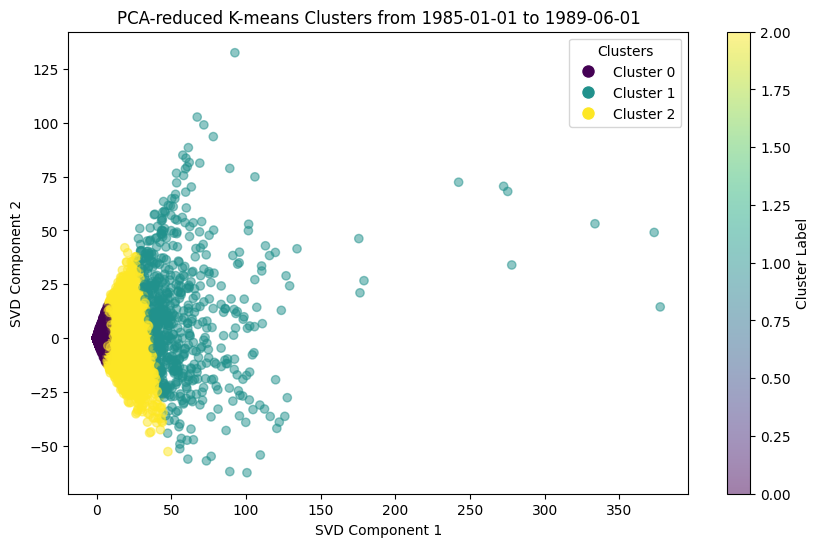

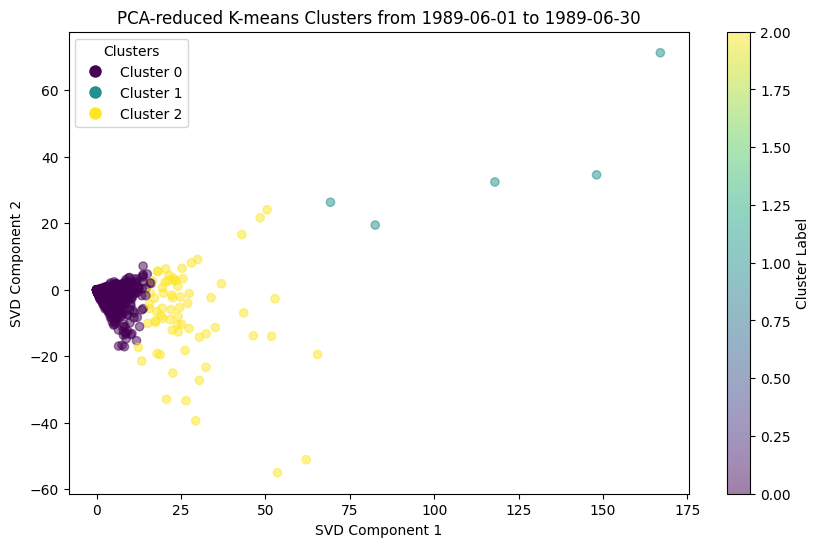

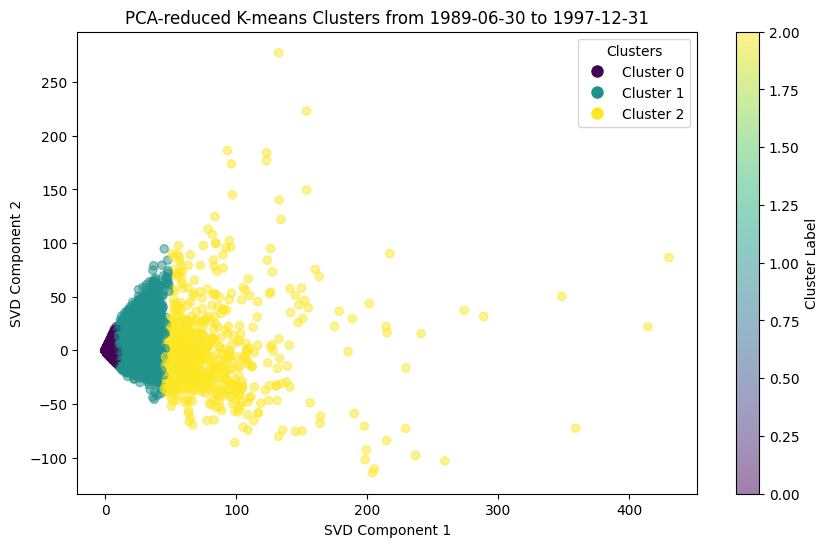

In [ ]:
for start_date, end_date in periods:
    # Filter the DataFrame for the current period
    period_df = preprocessed_df[(preprocessed_df['date'] >= start_date) & (preprocessed_df['date'] <= end_date)]

    # Vectorize the preprocessed text
    count_vectorizer = CountVectorizer(max_features=500)  # Adjust max_features as needed
    X = count_vectorizer.fit_transform(period_df['preprocessed_text'].fillna(""))

    # Use TruncatedSVD for dimensionality reduction
    svd = TruncatedSVD(n_components=2, random_state=42)
    reduced_data = svd.fit_transform(X)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(reduced_data)
    clusters = kmeans.predict(reduced_data)

    # Create a scatter plot with a legend that shows which color corresponds to which cluster
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', alpha=0.5)

    # Generate a color map based on the number of clusters
    colors = [scatter.cmap(scatter.norm(cluster_id)) for cluster_id in range(num_clusters)]

    # Create a legend with cluster labels
    cluster_labels = [f'Cluster {i}' for i in range(num_clusters)]
    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=cluster_labels[i],
                                   markersize=10, markerfacecolor=colors[i]) for i in range(num_clusters)],
               title='Clusters')

    plt.title(f"PCA-reduced K-means Clusters from {start_date} to {end_date}")
    plt.xlabel("SVD Component 1")
    plt.ylabel("SVD Component 2")
    plt.colorbar(scatter, label='Cluster Label')
    plt.show()

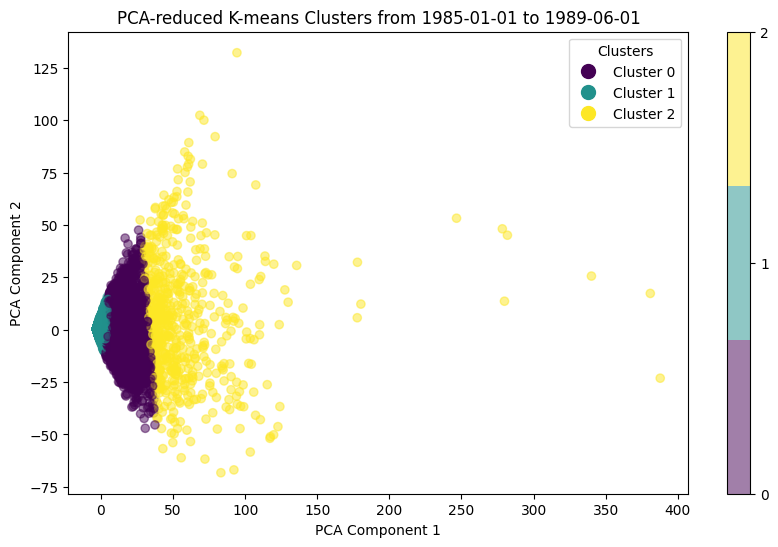

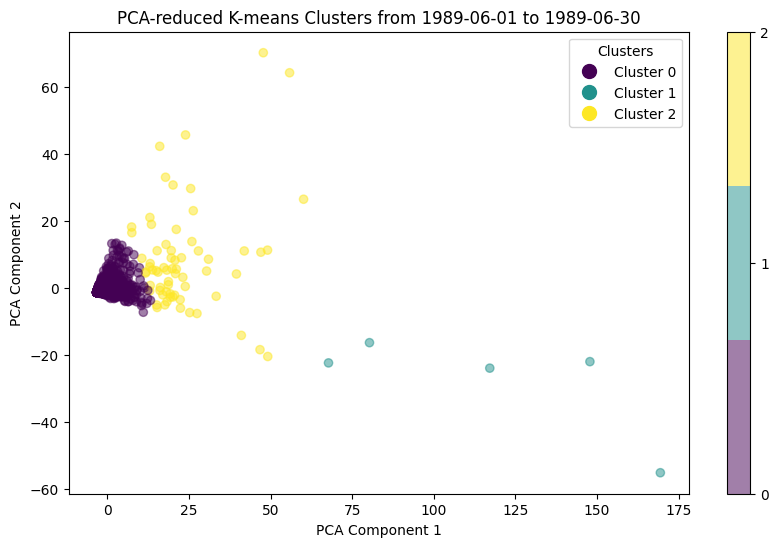

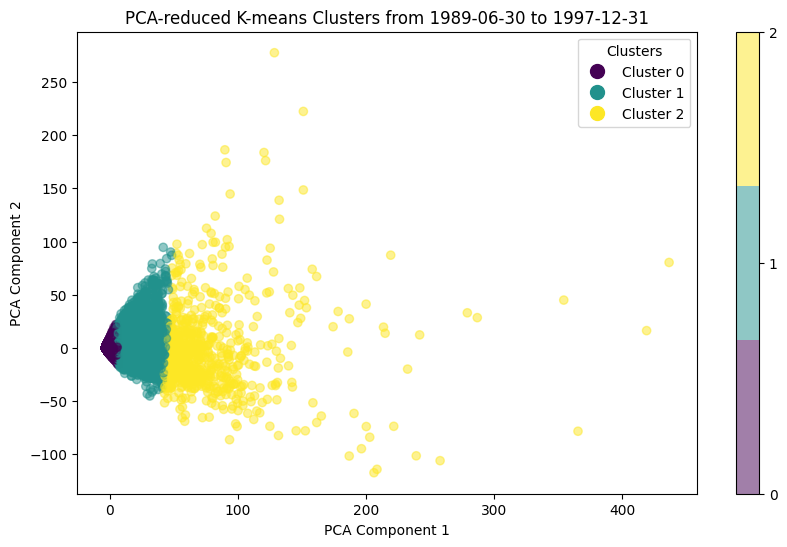

In [ ]:
cmap = plt.cm.get_cmap('viridis', num_clusters)

for start_date, end_date in periods:
    period_df = preprocessed_df[(preprocessed_df['date'] >= start_date) & (preprocessed_df['date'] <= end_date)]
    text_data = period_df['preprocessed_text'].fillna("").tolist()

    # Vectorize text data
    count_vectorizer = CountVectorizer(max_features=500)  # Reduced number of features
    X = count_vectorizer.fit_transform(text_data)

    # Convert to dense array if not too large, otherwise consider using TruncatedSVD
    X_dense = X.toarray()

    # Apply PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(X_dense)

    # Perform K-means clustering
    km = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = km.fit_predict(reduced_data)

    # Plot the reduced data
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap=cmap, alpha=0.5)

    # Create a legend with cluster labels
    cluster_labels = [f'Cluster {i}' for i in range(num_clusters)]
    handles = [plt.Line2D([], [], marker="o", ls="", color=cmap(i), label=cluster_labels[i],
                          markersize=10, markerfacecolor=cmap(i)) for i in range(num_clusters)]
    plt.legend(handles=handles, title='Clusters')

    plt.title(f"PCA-reduced K-means Clusters from {start_date} to {end_date}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(scatter, ticks=np.arange(num_clusters))
    plt.show()

##performing syhoutte analysis

For n_clusters = 2, the silhouette score is 0.6671
For n_clusters = 3, the silhouette score is 0.5512
For n_clusters = 4, the silhouette score is 0.5588
For n_clusters = 5, the silhouette score is 0.5813
For n_clusters = 6, the silhouette score is 0.5195
For n_clusters = 7, the silhouette score is 0.4760
For n_clusters = 8, the silhouette score is 0.5348
For n_clusters = 9, the silhouette score is 0.4933


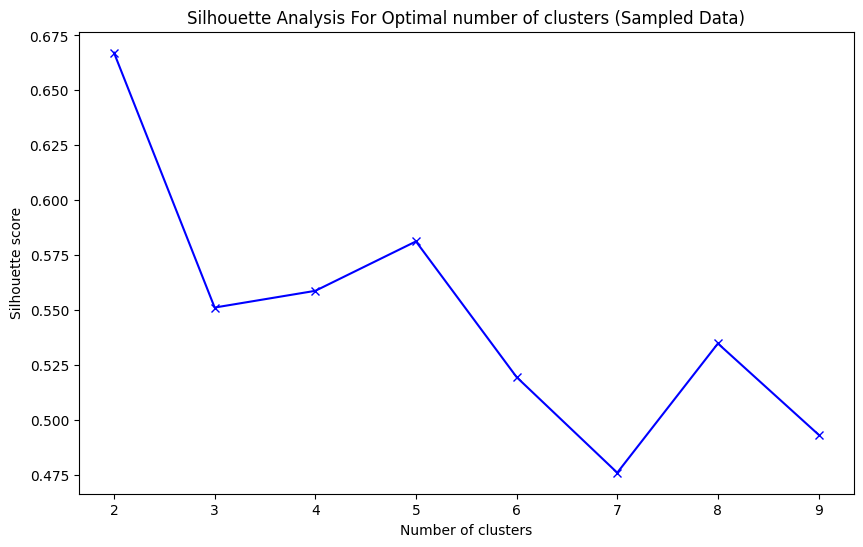

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.utils import resample

text_data = preprocessed_df['preprocessed_text'].fillna("").tolist()

# Vectorize text data
count_vectorizer = CountVectorizer(max_features=500)  # Reduced number of features
X = count_vectorizer.fit_transform(text_data)

# Sample a subset of the data for silhouette score calculation
sample_size = 1000  # Adjust this to a reasonable size that fits in memory and can be computed faster
X_sample = resample(X, n_samples=sample_size, random_state=42, replace=False)

# Range of clusters to try
cluster_range = range(2, 10)

silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_sample)

    # Compute the silhouette scores for the sample
    silhouette_avg = silhouette_score(X_sample, cluster_labels)

    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg:.4f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette Analysis For Optimal number of clusters (Sampled Data)')
plt.show()



##2 clusters for optimal results

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

# Assuming 'preprocessed_df' has a 'preprocessed_text' column and a 'date' column
preprocessed_df['date'] = pd.to_datetime(preprocessed_df['date'])  # Ensure 'date' is datetime type

# Define time periods
periods = [
    ("1985-01-01", "1989-06-01"),
    ("1989-06-01", "1989-06-30"),
    ("1989-06-30", "1995-12-31")
]

# Number of clusters for K-means
num_clusters = 2

for start_date, end_date in periods:
    # Filter the DataFrame for the current period
    period_df = preprocessed_df[(preprocessed_df['date'] >= start_date) & (preprocessed_df['date'] <= end_date)]

    # Vectorize the preprocessed text
    count_vectorizer = CountVectorizer()
    X = count_vectorizer.fit_transform(period_df['preprocessed_text'].fillna("").tolist())

    # Perform K-means clustering
    km = KMeans(n_clusters=num_clusters, random_state=42)
    km.fit(X)

    # Get the feature names (terms) from the vectorizer
    terms = count_vectorizer.get_feature_names_out()

    # Get the order of centroids
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    print(f"Top terms per cluster for period {start_date} to {end_date}:")
    for i in range(num_clusters):
        print(f"Cluster {i}:")
        for ind in order_centroids[i, :10]:  # Get top 10 terms per cluster
            print(f" {terms[ind]}")
        print("\n")

Top terms per cluster for period 1985-01-01 to 1989-06-01:
Cluster 0:
 中国
 发展
 问题
 工作
 国家
 经济
 新华社
 进行
 记者
 企业


Cluster 1:
 发展
 经济
 企业
 改革
 工作
 问题
 国家
 同志
 社会主义
 建设


Top terms per cluster for period 1989-06-01 to 1989-06-30:
Cluster 0:
 中国
 北京
 人民
 问题
 暴乱
 工作
 日电
 国家
 新华社
 部队


Cluster 1:
 暴乱
 党中央
 反革命
 国务院
 人民
 工作
 学生
 平息
 部队
 同志


Top terms per cluster for period 1989-06-30 to 1997-12-31:
Cluster 0:
 中国
 发展
 经济
 工作
 国家
 问题
 记者
 企业
 北京
 进行


Cluster 1:
 发展
 经济
 社会主义
 企业
 建设
 中国
 工作
 问题
 国家
 同志




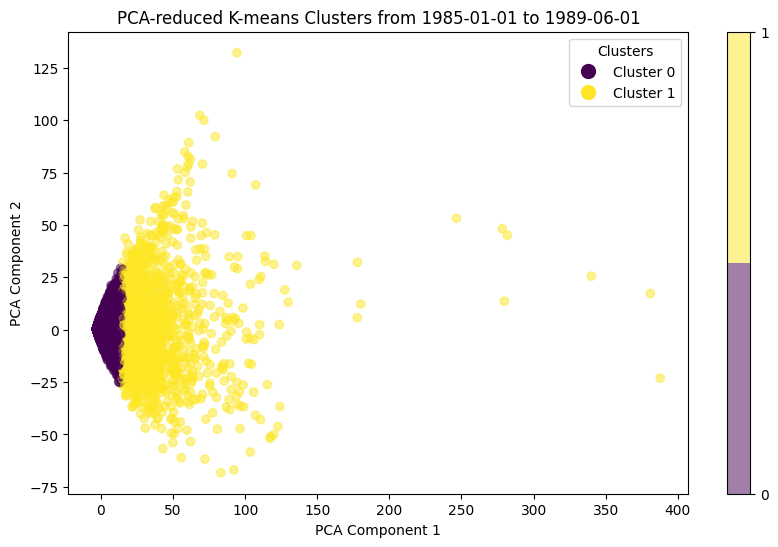

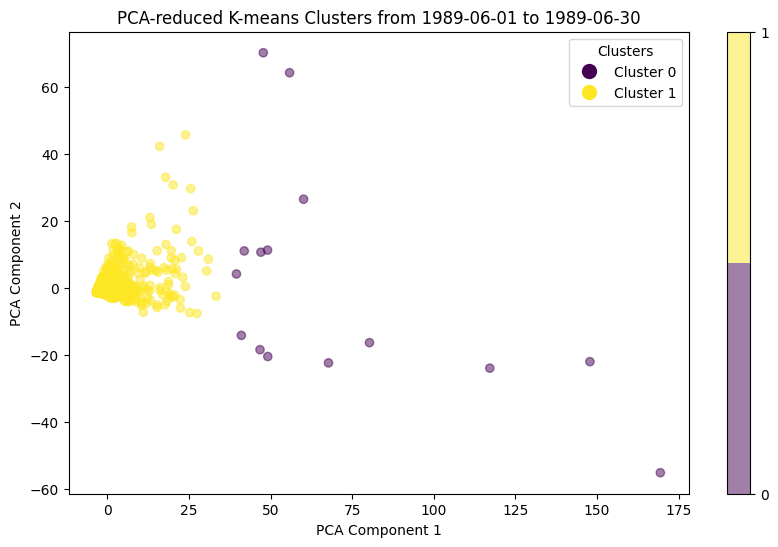

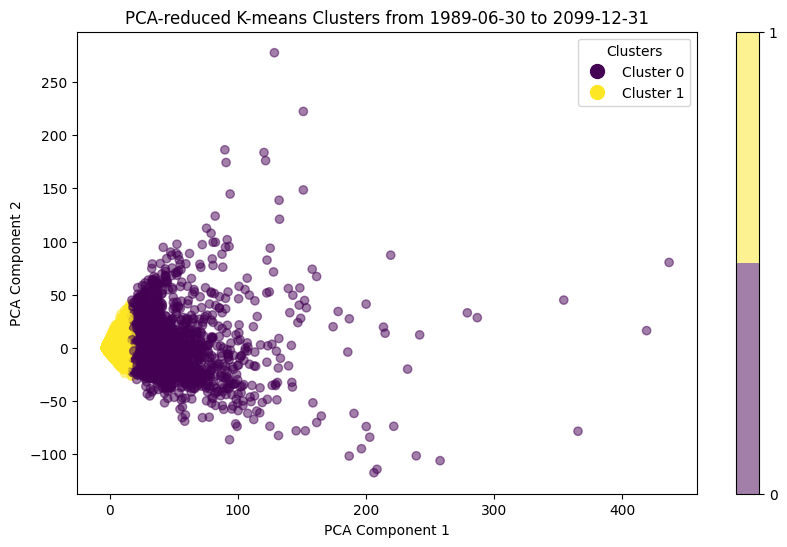

In [ ]:
num_clusters = 2
cmap = plt.cm.get_cmap('viridis', num_clusters)

for start_date, end_date in periods:
    period_df = preprocessed_df[(preprocessed_df['date'] >= start_date) & (preprocessed_df['date'] <= end_date)]
    text_data = period_df['preprocessed_text'].fillna("").tolist()

    # Vectorize text data
    count_vectorizer = CountVectorizer(max_features=500)  # Reduced number of features
    X = count_vectorizer.fit_transform(text_data)

    # Convert to dense array if not too large, otherwise consider using TruncatedSVD
    X_dense = X.toarray()

    # Apply PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(X_dense)

    # Perform K-means clustering
    km = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = km.fit_predict(reduced_data)

    # Plot the reduced data
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap=cmap, alpha=0.5)

    # Create a legend with cluster labels
    cluster_labels = [f'Cluster {i}' for i in range(num_clusters)]
    handles = [plt.Line2D([], [], marker="o", ls="", color=cmap(i), label=cluster_labels[i],
                          markersize=10, markerfacecolor=cmap(i)) for i in range(num_clusters)]
    plt.legend(handles=handles, title='Clusters')

    plt.title(f"PCA-reduced K-means Clusters from {start_date} to {end_date}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(scatter, ticks=np.arange(num_clusters))
    plt.show()

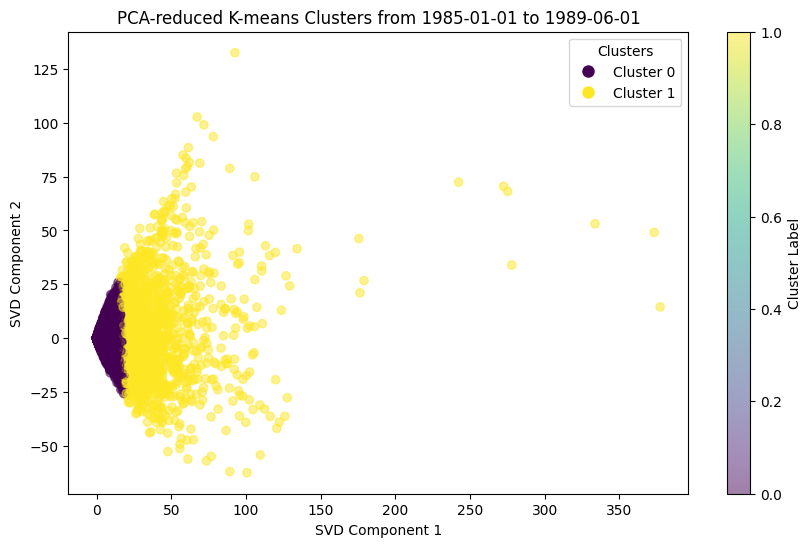

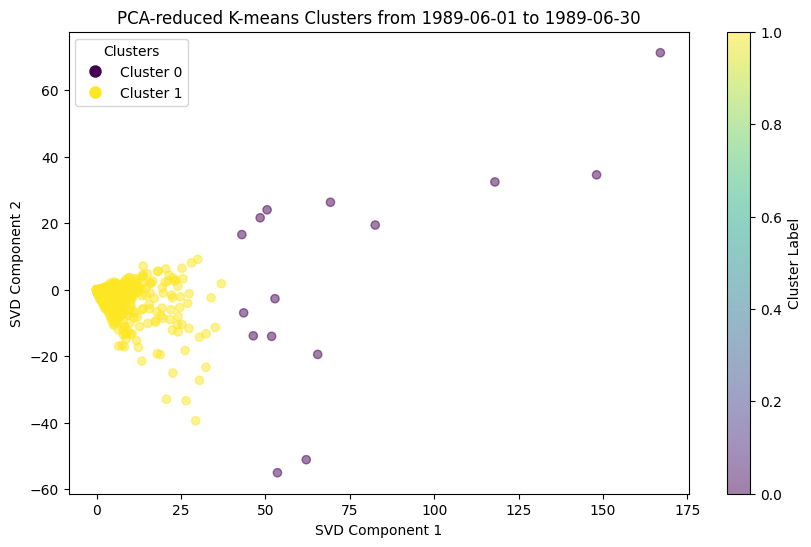

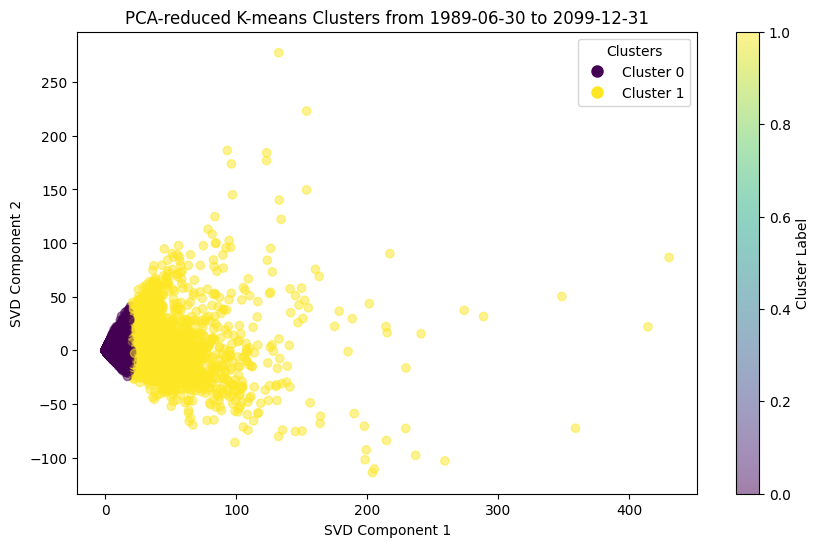

In [ ]:
for start_date, end_date in periods:
    # Filter the DataFrame for the current period
    period_df = preprocessed_df[(preprocessed_df['date'] >= start_date) & (preprocessed_df['date'] <= end_date)]

    # Vectorize the preprocessed text
    count_vectorizer = CountVectorizer(max_features=500)  # Adjust max_features as needed
    X = count_vectorizer.fit_transform(period_df['preprocessed_text'].fillna(""))

    # Use TruncatedSVD for dimensionality reduction
    svd = TruncatedSVD(n_components=2, random_state=42)
    reduced_data = svd.fit_transform(X)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(reduced_data)
    clusters = kmeans.predict(reduced_data)

    # Create a scatter plot with a legend that shows which color corresponds to which cluster
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', alpha=0.5)

    # Generate a color map based on the number of clusters
    colors = [scatter.cmap(scatter.norm(cluster_id)) for cluster_id in range(num_clusters)]

    # Create a legend with cluster labels
    cluster_labels = [f'Cluster {i}' for i in range(num_clusters)]
    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=cluster_labels[i],
                                   markersize=10, markerfacecolor=colors[i]) for i in range(num_clusters)],
               title='Clusters')

    plt.title(f"PCA-reduced K-means Clusters from {start_date} to {end_date}")
    plt.xlabel("SVD Component 1")
    plt.ylabel("SVD Component 2")
    plt.colorbar(scatter, label='Cluster Label')
    plt.show()

Selected document indices for the period 1985-01-01 to 1989-06-01: [56077, 6873, 116118, 113137, 145998, 70161, 55836, 80095, 3418, 83939]


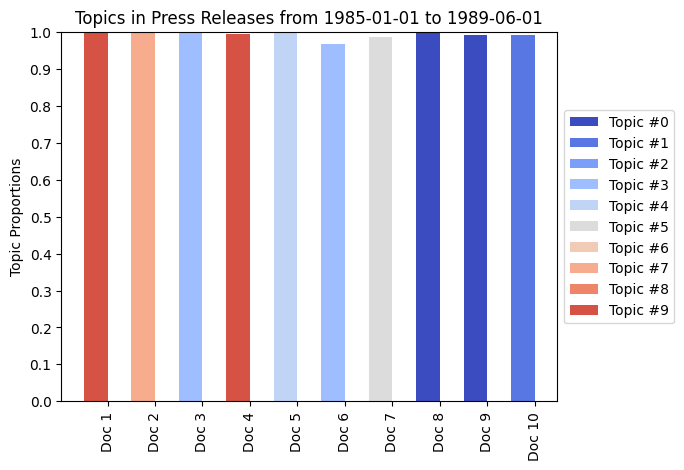

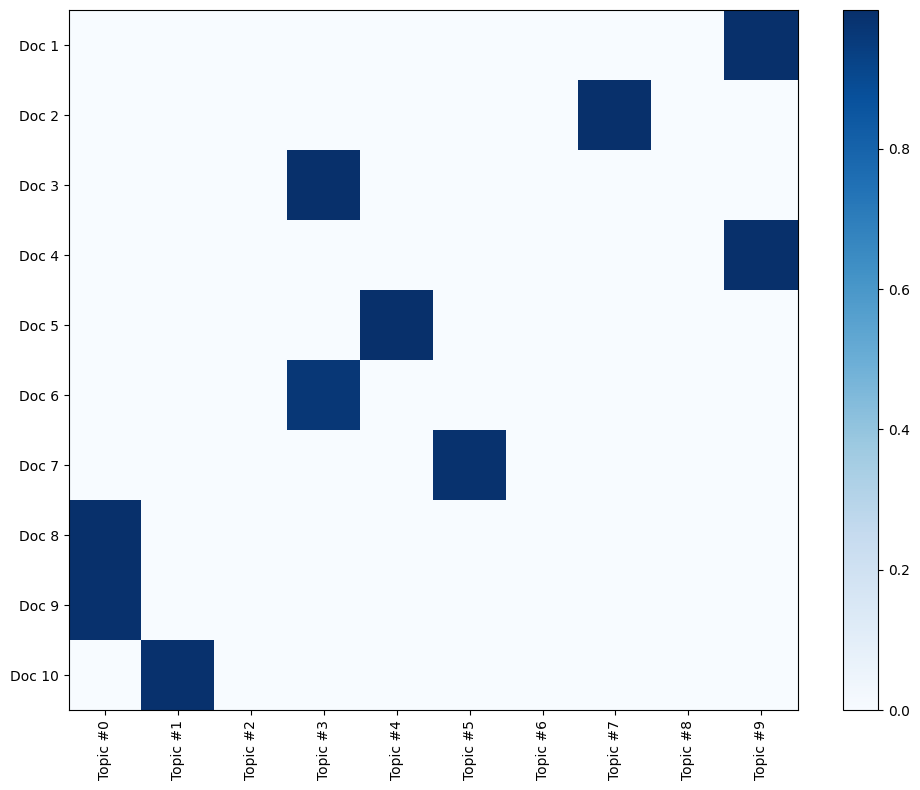

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel
import pandas as pd

# Ensure 'date' is a datetime type
preprocessed_df['date'] = pd.to_datetime(preprocessed_df['date'])

# Function to perform LDA and visualize the results for a given time period
def lda_visualization(preprocessed_df, start_date, end_date, num_topics=10):
    # Filter the DataFrame for the current period and reset the index
    period_df = preprocessed_df[(preprocessed_df['date'] >= start_date) & (preprocessed_df['date'] <= end_date)].reset_index(drop=True)

    # Randomly select 10 documents from the current period and store their indices
    selected_indices = period_df.sample(10, random_state=42).index.tolist()
    selected_texts = period_df.loc[selected_indices, 'preprocessed_text'].tolist()

    # Assuming preprocessed_text are space-separated strings, convert to lists of tokens
    selected_texts = [text.split() for text in selected_texts]

    # Print out the indices of the selected documents
    print(f"Selected document indices for the period {start_date} to {end_date}: {selected_indices}")

    # Create a dictionary and corpus for LDA
    dictionary = corpora.Dictionary(selected_texts)
    corpus = [dictionary.doc2bow(text) for text in selected_texts]

    # Create an LDA model
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)

    lda_topic_distributions = np.array([[dict(doc_topic_dist).get(i, 0) for i in range(num_topics)]
                                        for doc_topic_dist in lda_model[corpus]])

    # Plot the bar chart for the topic distributions
    N = len(selected_texts)
    ind = np.arange(N)
    width = 0.5  # the width of the bars
    plots = []
    height_cumulative = np.zeros(N)

    for k in range(num_topics):
        color = plt.cm.coolwarm(k / num_topics, 1)
        if k == 0:
            p = plt.bar(ind, lda_topic_distributions[:, k], width, color=color)
        else:
            p = plt.bar(ind, lda_topic_distributions[:, k], width, bottom=height_cumulative, color=color)
        height_cumulative += lda_topic_distributions[:, k]
        plots.append(p)

    plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
    plt.ylabel('Topic Proportions')
    plt.title(f'Topics in Press Releases from {start_date} to {end_date}')
    plt.xticks(ind + width/2, [f'Doc {i+1}' for i in range(N)], rotation='vertical')
    plt.yticks(np.arange(0, 1.1, 0.1))
    topic_labels = [f'Topic #{k}' for k in range(num_topics)]
    plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True, bbox_to_anchor=(1, 0.5))
    plt.show()

    # Plot the heatmap for the topic distributions
    plt.figure(figsize=(10, 8))
    plt.pcolor(lda_topic_distributions, norm=None, cmap='Blues')
    plt.yticks(np.arange(lda_topic_distributions.shape[0]) + 0.5, [f'Doc {i+1}' for i in range(N)])
    plt.xticks(np.arange(lda_topic_distributions.shape[1]) + 0.5, topic_labels, rotation=90)
    plt.gca().invert_yaxis()
    plt.colorbar(cmap='Blues')
    plt.tight_layout()
    plt.show()


# Define the time period for visualization
start_period = '1985-01-01'
end_period = '1989-06-01'

# Perform LDA visualization for the defined time period
lda_visualization(preprocessed_df, start_period, end_period, num_topics=10)


Selected document indices for the period 1989-06-01 to 1989-06-30: [705, 809, 1432, 173, 513, 1649, 818, 261, 405, 1399]


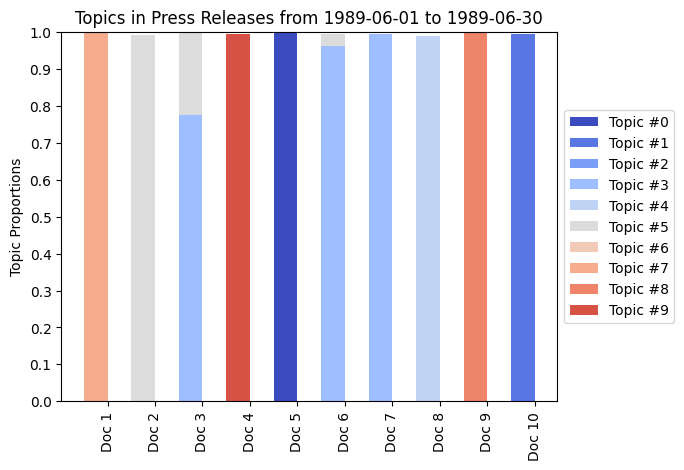

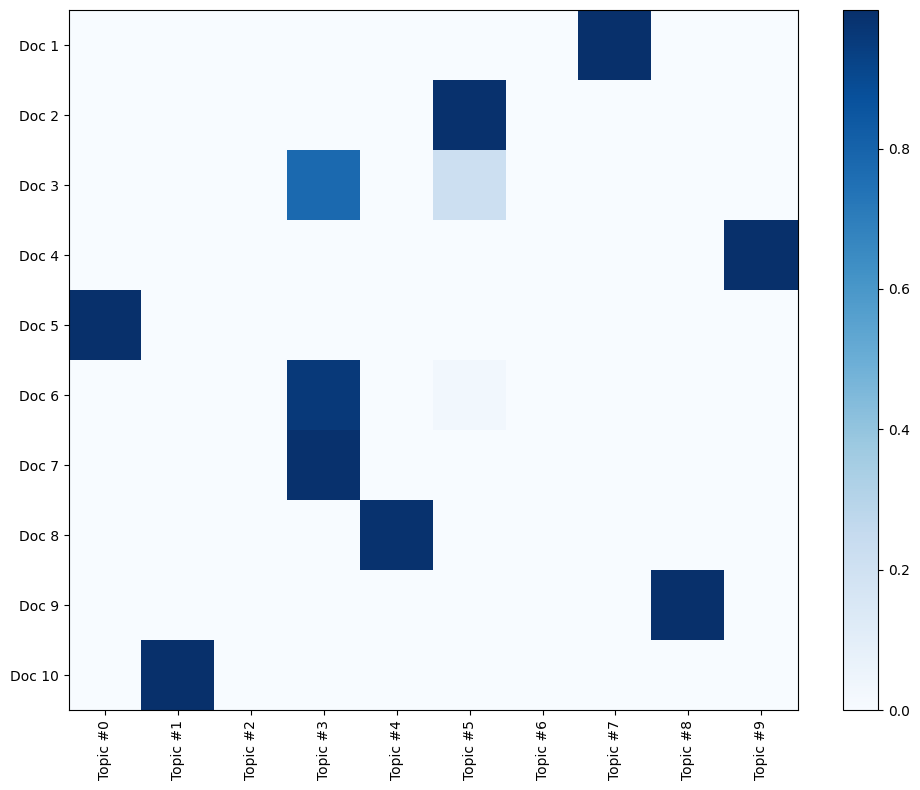

In [ ]:
start_period = '1989-06-01'
end_period = '1989-06-30'

# Perform LDA visualization for the defined time period
lda_visualization(preprocessed_df, start_period, end_period, num_topics=10)

Selected document indices for the period 1989-06-30 to 1997-12-31: [104295, 90707, 26963, 32346, 211084, 99336, 185743, 35937, 209390, 113869]


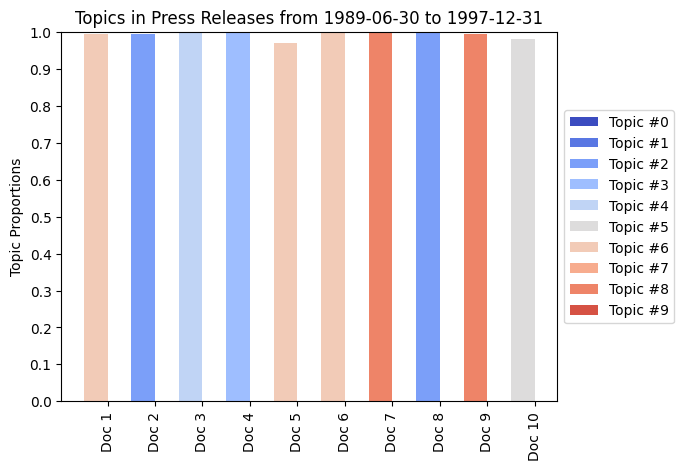

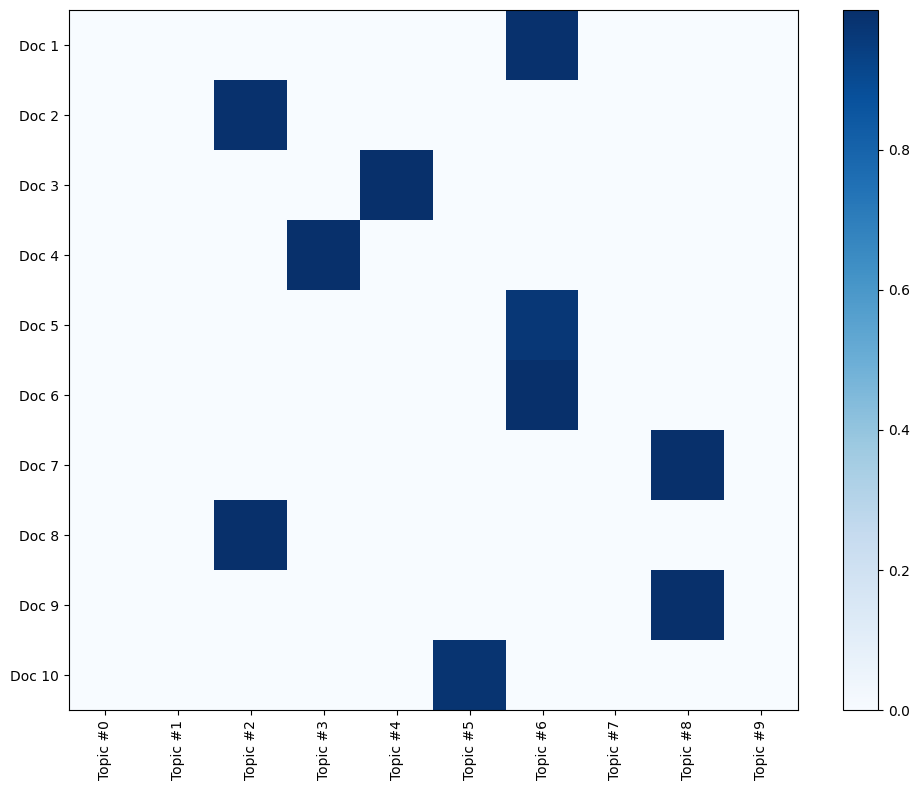

In [ ]:
start_period = '1989-06-30'
end_period = '1997-12-31'

# Perform LDA visualization for the defined time period
lda_visualization(preprocessed_df, start_period, end_period, num_topics=10)

#Week 4 - Exploring Semantic Spaces

Most similar to 中国:
[('我国', 0.7030802369117737), ('中国政府', 0.6305346488952637), ('苏联', 0.6163197755813599), ('贵国', 0.6072809100151062), ('欧洲', 0.5909892916679382), ('波兰', 0.5741302967071533), ('两国', 0.5730865001678467), ('南斯拉夫', 0.5680127143859863), ('中华人民共和国', 0.5672465562820435), ('世界', 0.5627360939979553)]


Most similar to 发展:
[('大力发展', 0.7340899705886841), ('稳步发展', 0.7054737210273743), ('蓬勃发展', 0.6690223217010498), ('迅猛发展', 0.5955519676208496), ('发展趋势', 0.5917786955833435), ('繁荣', 0.5914967060089111), ('振兴', 0.5777648687362671), ('飞跃发展', 0.5772587060928345), ('增长', 0.57450932264328), ('发达', 0.5740273594856262)]


Most similar to 问题:
[('关键问题', 0.7629868984222412), ('矛盾', 0.6707044839859009), ('当前', 0.6520300507545471), ('难题', 0.6090514063835144), ('热点问题', 0.6027248501777649), ('分歧', 0.597825288772583), ('难点', 0.5764718651771545), ('课题', 0.5690202713012695), ('着重', 0.5542129874229431), ('方面', 0.5533426403999329)]


Most similar to 工作:
[('管理工作', 0.6811923384666443), ('统战工作', 0.6538279

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39535 (\N{CJK UNIFIED IDEOGRAPH-9A6F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24439 (\N{CJK UNIFIED IDEOGRAPH-5F77}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24488 (\N{CJK UNIFIED IDEOGRAPH-5FA8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26179 (\N{CJK UNIFIED IDEOGRAPH-6643}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24812 (\N{CJK UNIFIED IDEOGRAPH-60EC}) missing from current fo

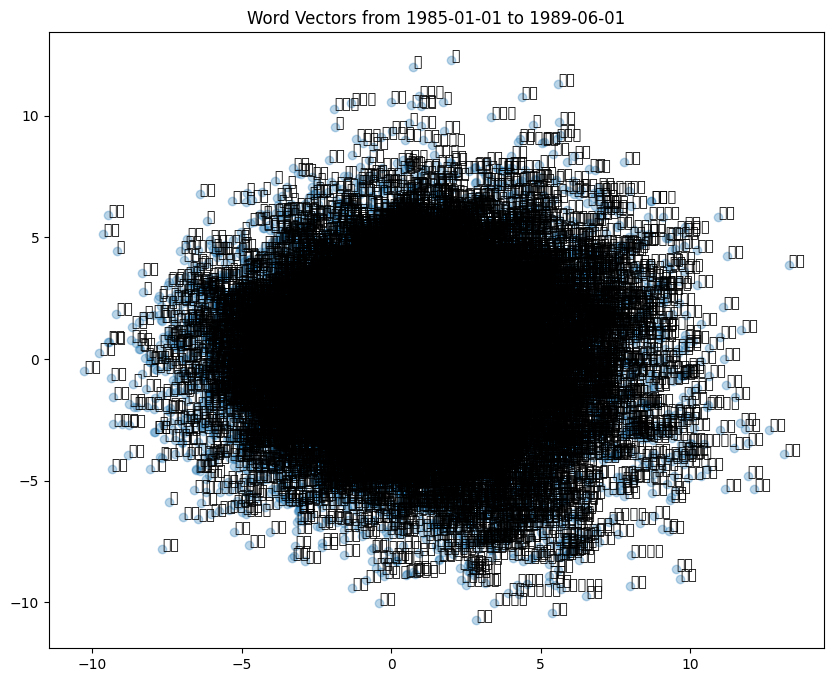

Most similar to 中国:
[('内政', 0.9023150205612183), ('干涉', 0.8967094421386719), ('内部事务', 0.8166211843490601), ('国际商会', 0.8023862242698669), ('不明智', 0.7919975519180298), ('关系', 0.7901778221130371), ('纯属', 0.7844425439834595), ('保护环境', 0.7835153341293335), ('朝鲜', 0.7820941209793091), ('外国', 0.7751814723014832)]


Most similar to 发展:
[('文化', 0.938534677028656), ('我国', 0.938257098197937), ('关系', 0.9380521774291992), ('友好关系', 0.9358397126197815), ('经济', 0.9344563484191895), ('历史', 0.9315871000289917), ('社会', 0.9308943152427673), ('对外贸易', 0.9215236902236938), ('友好合作', 0.9195445775985718), ('建立', 0.9185650944709778)]


Most similar to 问题:
[('解决', 0.955008864402771), ('中东问题', 0.9084897637367249), ('外来干涉', 0.8803666830062866), ('政府', 0.8795089721679688), ('关系', 0.8783266544342041), ('和平', 0.8738065361976624), ('方面', 0.8653622269630432), ('印支', 0.8622504472732544), ('进行', 0.8571777939796448), ('双方', 0.8552592992782593)]


Most similar to 工作:
[('做好', 0.9429956674575806), ('思想', 0.9338342547416687), 

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65297 (\N{FULLWIDTH DIGIT ONE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65296 (\N{FULLWIDTH DIGIT ZERO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65302 (\N{FULLWIDTH DIGIT SIX}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65298 (\N{FULLWIDTH DIGIT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-p

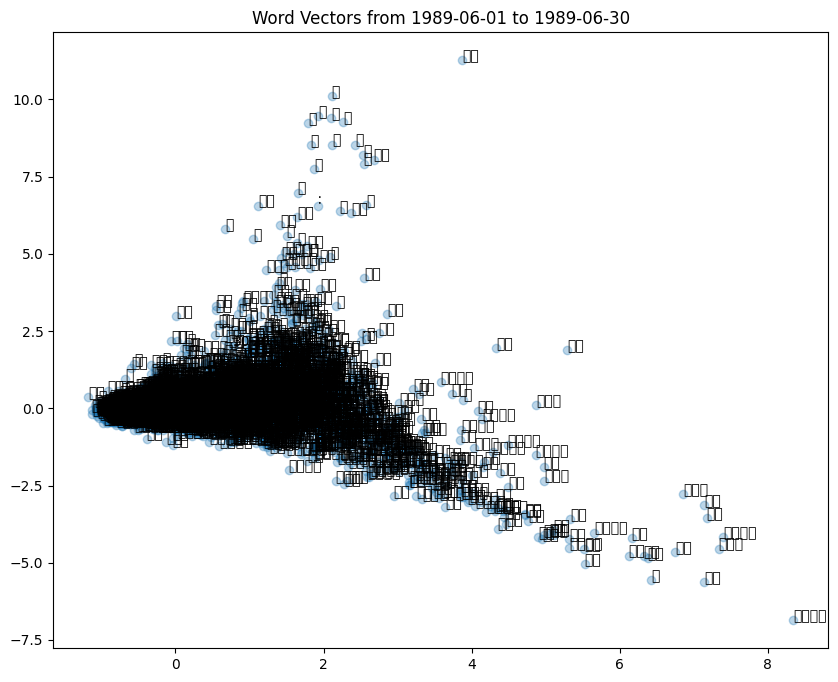

Most similar to 中国:
[('我国', 0.7651221752166748), ('中国政府', 0.6632452011108398), ('亚洲', 0.6337032914161682), ('各国', 0.6074422597885132), ('大陆', 0.5840607285499573), ('世界', 0.5797762274742126), ('本国', 0.5723968148231506), ('古巴', 0.5683798789978027), ('两国', 0.5659551024436951), ('中华人民共和国', 0.5658987760543823)]


Most similar to 发展:
[('大力发展', 0.7062893509864807), ('稳步发展', 0.6990010738372803), ('蓬勃发展', 0.6252135634422302), ('迅猛发展', 0.6221615076065063), ('振兴', 0.589333176612854), ('推进', 0.5860702395439148), ('推动', 0.5823927521705627), ('飞速发展', 0.5807744860649109), ('繁荣', 0.5797714591026306), ('发达', 0.5791632533073425)]


Most similar to 问题:
[('关键问题', 0.7683640718460083), ('热点问题', 0.6622216701507568), ('腐败问题', 0.6536732912063599), ('矛盾', 0.6503221392631531), ('分歧', 0.6277285218238831), ('当前', 0.6055682301521301), ('难题', 0.5948694348335266), ('领土问题', 0.5862900018692017), ('方面', 0.5850750803947449), ('危机', 0.583001971244812)]


Most similar to 工作:
[('管理工作', 0.7163364887237549), ('本职工作', 0.646118

流式输出内容被截断，只能显示最后 5000 行内容。
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26095 (\N{CJK UNIFIED IDEOGRAPH-65EF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36726 (\N{CJK UNIFIED IDEOGRAPH-8F76}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30066 (\N{CJK UNIFIED IDEOGRAPH-7572}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26238 (\N{CJK UNIFIED IDEOGRAPH-667E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 33862 (\N{CJK UNIFIED IDEOGRAPH-8446}) missing from current font.
  fig.canvas.print_f

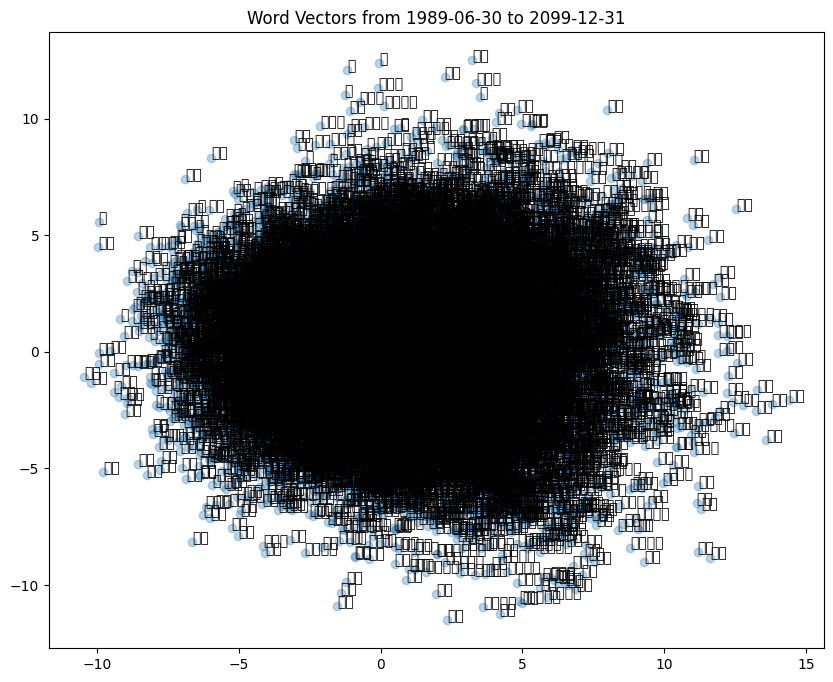

In [ ]:
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Convert 'date' to datetime and ensure 'preprocessed_text' contains lists of words
preprocessed_df['date'] = pd.to_datetime(preprocessed_df['date'])
# Fill NaN values with an empty string and split strings into tokens
preprocessed_df['tokenized_text'] = preprocessed_df['preprocessed_text'].fillna("").apply(lambda text: text.split())

# Define your time periods
periods = [
    ("1985-01-01", "1989-06-01"),
    ("1989-06-01", "1989-06-30"),
    ("1989-06-30", "2099-12-31")
]

# Define a function to train Word2Vec for each period and visualize the results
def train_and_visualize_word2vec(preprocessed_df, start_date, end_date, num_topics=10):
    period_df = preprocessed_df[(preprocessed_df['date'] >= start_date) & (preprocessed_df['date'] <= end_date)]

    # Train Word2Vec model
    model = gensim.models.Word2Vec(period_df['tokenized_text'], vector_size=100, window=5, min_count=5, workers=4)

    # Get target words (you can choose different words of interest)
    target_words = ['中国','发展', '问题', '工作', '国家', '经济', '企业', '同志','社会主义']
    # Example words in Chinese

    # Find similar words and words that don't match
    for word in target_words:
        if word in model.wv:
            print(f"Most similar to {word}:")
            print(model.wv.most_similar(word))
            print("\n")

    # Visualize word vectors
    words = sum([[k] for k, v in model.wv.key_to_index.items()], [])
    word_vectors = np.array([model.wv[w] for w in words])

    # Reduce dimensions with PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(word_vectors)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.3)
    for i, word in enumerate(words):
        plt.annotate(word, xy=(pca_result[i, 0], pca_result[i, 1]))
    plt.title(f"Word Vectors from {start_date} to {end_date}")
    plt.show()

# Apply the function to each time period
for start_date, end_date in periods:
    train_and_visualize_word2vec(preprocessed_df, start_date, end_date, num_topics=10)



/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22269 (\N{CJK UNIFIED IDEOGRAPH-56FD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21457 (\N{CJK UNIFIED IDEOGRAPH-53D1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23637 (\N{CJK UNIFIED IDEOGRAPH-5C55}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38382 (\N{CJK UNIFIED IDEOGRAPH-95EE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

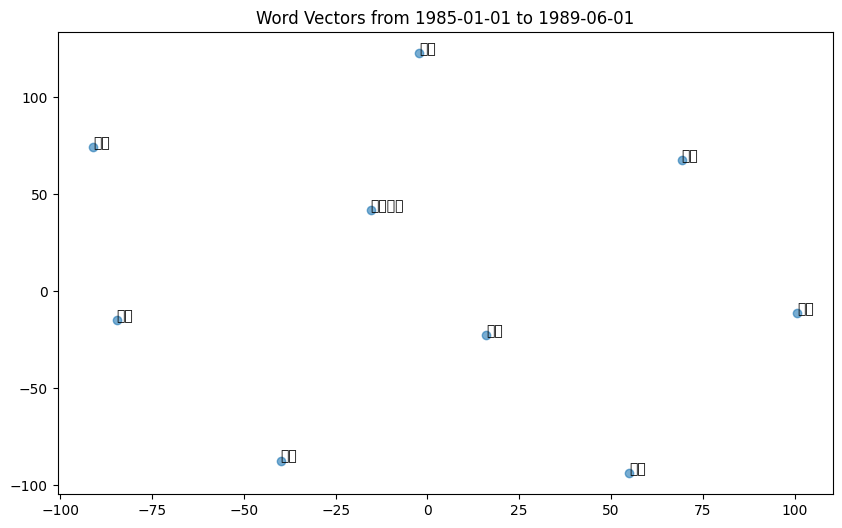

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22269 (\N{CJK UNIFIED IDEOGRAPH-56FD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21457 (\N{CJK UNIFIED IDEOGRAPH-53D1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23637 (\N{CJK UNIFIED IDEOGRAPH-5C55}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38382 (\N{CJK UNIFIED IDEOGRAPH-95EE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

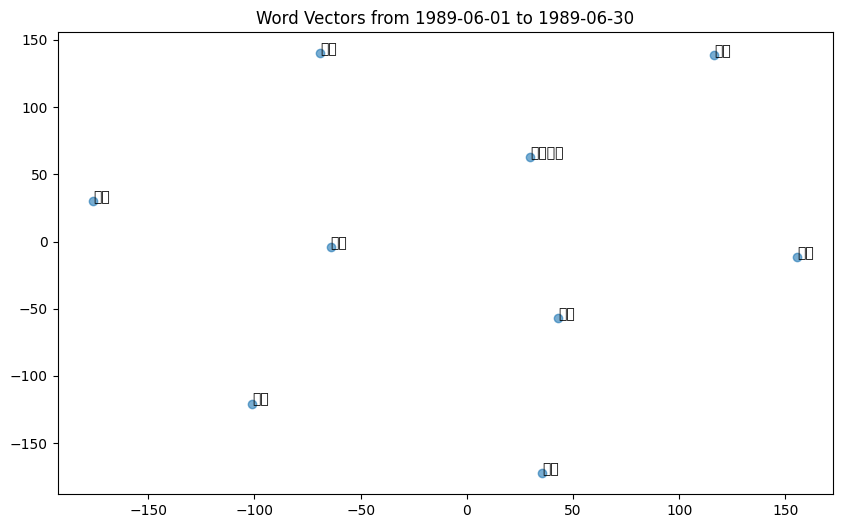

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22269 (\N{CJK UNIFIED IDEOGRAPH-56FD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21457 (\N{CJK UNIFIED IDEOGRAPH-53D1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23637 (\N{CJK UNIFIED IDEOGRAPH-5C55}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38382 (\N{CJK UNIFIED IDEOGRAPH-95EE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

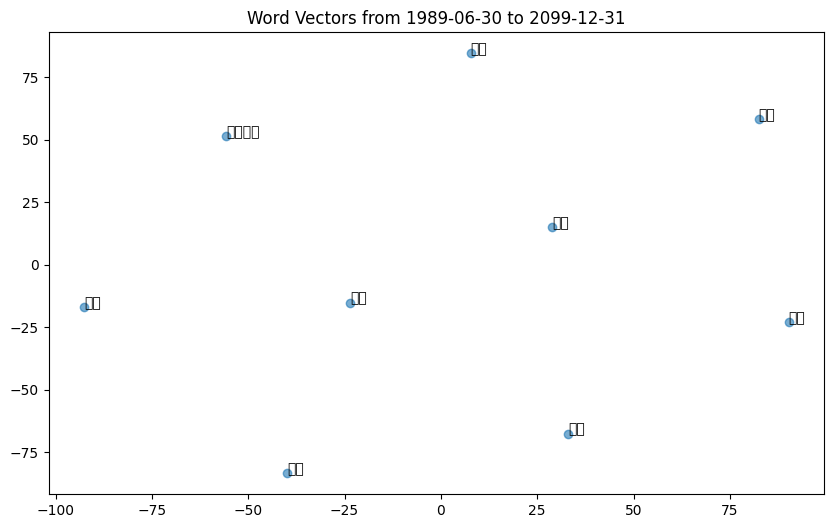

In [ ]:
import gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Set the font for matplotlib
plt.rcParams['font.sans-serif'] = ['SimHei']  # or another font that supports Chinese

# Convert 'date' to datetime and handle missing or non-string values in 'preprocessed_text'
preprocessed_df['date'] = pd.to_datetime(preprocessed_df['date'])
preprocessed_df.dropna(subset=['preprocessed_text'], inplace=True)
preprocessed_df['tokenized_text'] = preprocessed_df['preprocessed_text'].apply(lambda x: x.split())

# Define your time periods
periods = [
    ("1985-01-01", "1989-06-01"),
    ("1989-06-01", "1989-06-30"),
    ("1989-06-30", "2099-12-31")
]

# Function to train Word2Vec for each period and visualize the results
# Function to train Word2Vec for each period and visualize the results
def train_and_visualize_word2vec(preprocessed_df, start_date, end_date):
    period_df = preprocessed_df[(preprocessed_df['date'] >= pd.to_datetime(start_date)) &
                                (preprocessed_df['date'] <= pd.to_datetime(end_date))]

    sentences = period_df['tokenized_text'].tolist()

    # Train Word2Vec model
    model = gensim.models.Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

    # Define target words for visualization
    target_words = ['中国','发展', '问题', '工作', '国家', '经济', '企业', '同志','社会主义']

    # Filter words that are actually in the model's vocabulary
    filtered_words = [word for word in target_words if word in model.wv.key_to_index]

    # Extract vectors for filtered target words
    word_vectors = np.array([model.wv[word] for word in filtered_words])

    # Use t-SNE for dimensionality reduction
    tsne_perplexity = len(filtered_words) - 1  # Perplexity must be less than the number of samples
    tsne = TSNE(n_components=2, random_state=42, perplexity=tsne_perplexity)
    reduced_vectors = tsne.fit_transform(word_vectors)

    # Plotting the reduced vectors
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], alpha=0.6)
    for i, word in enumerate(filtered_words):
        plt.annotate(word, xy=(reduced_vectors[i, 0], reduced_vectors[i, 1]))
    plt.title(f"Word Vectors from {start_date} to {end_date}")
    plt.show()

# Apply the function to each time period
for start_date, end_date in periods:
    train_and_visualize_word2vec(preprocessed_df, start_date, end_date)


Most similar to 中国:
[('我国', 0.7131113409996033), ('中国政府', 0.6656301021575928), ('苏联', 0.6288684606552124), ('各国', 0.5948793888092041), ('贵国', 0.5906410217285156), ('波兰', 0.5841530561447144), ('中华人民共和国', 0.5814998149871826), ('南斯拉夫', 0.5706836581230164), ('两国', 0.5616997480392456), ('本国', 0.5543753504753113)]


Most similar to 发展:
[('大力发展', 0.7411128878593445), ('稳步发展', 0.689061164855957), ('蓬勃发展', 0.6735772490501404), ('发达', 0.6113747358322144), ('推进', 0.5832034945487976), ('稳定增长', 0.58196622133255), ('迅猛发展', 0.5810511112213135), ('发展趋势', 0.5727121829986572), ('繁荣', 0.5683960318565369), ('振兴', 0.5660790205001831)]


Most similar to 问题:
[('关键问题', 0.7760637998580933), ('矛盾', 0.6551597118377686), ('当前', 0.6334104537963867), ('难题', 0.6120403409004211), ('分歧', 0.6040158867835999), ('难点', 0.5850402116775513), ('住房问题', 0.56573486328125), ('热点问题', 0.5615655183792114), ('失业问题', 0.5501024723052979), ('实际困难', 0.549888551235199)]


Most similar to 工作:
[('管理工作', 0.6924947500228882), ('科研工作', 0.6538

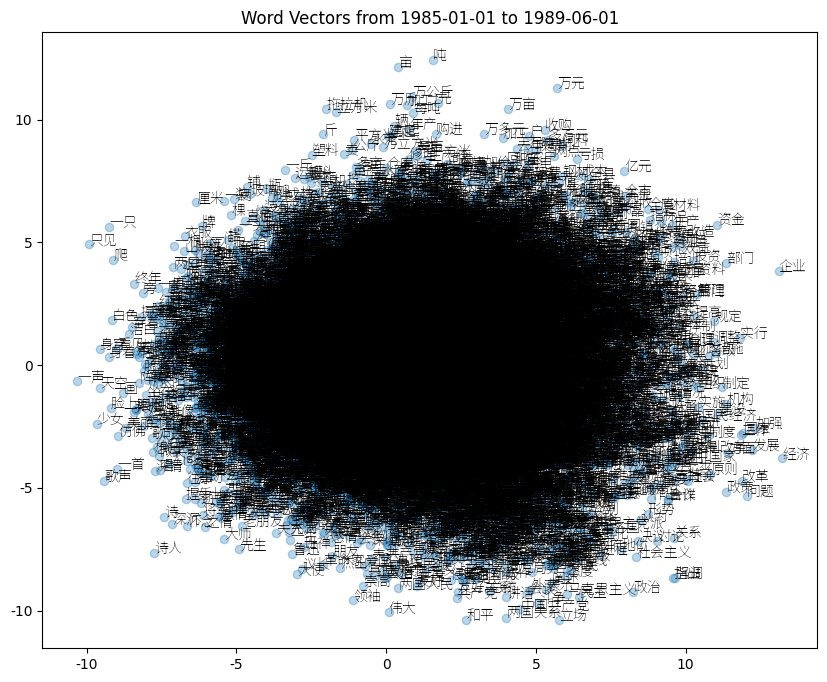

Most similar to 中国:
[('干涉', 0.8956106901168823), ('内政', 0.8931512236595154), ('内部事务', 0.8516287803649902), ('外来干涉', 0.8171964287757874), ('关系', 0.7966142892837524), ('正常化', 0.7904711961746216), ('朝鲜', 0.7863054275512695), ('不明智', 0.7787718176841736), ('外国', 0.7777404189109802), ('问及', 0.7741459012031555)]


Most similar to 发展:
[('我国', 0.9531219601631165), ('友好关系', 0.9384816884994507), ('关系', 0.9354496598243713), ('社会', 0.9304766058921814), ('经济', 0.9298464059829712), ('文化', 0.9217587113380432), ('步骤', 0.9181213974952698), ('互利', 0.9136401414871216), ('商品经济', 0.9123682975769043), ('历史', 0.9122504591941833)]


Most similar to 问题:
[('解决', 0.9460968375205994), ('关系', 0.8872714042663574), ('中东问题', 0.8853283524513245), ('一致意见', 0.883093535900116), ('双方', 0.8763428926467896), ('政府', 0.8730417490005493), ('方面', 0.86781907081604), ('和平', 0.8511133193969727), ('合作', 0.8501453399658203), ('防务', 0.84613037109375)]


Most similar to 工作:
[('做好', 0.9359481334686279), ('加强', 0.9258149266242981), ('思想'

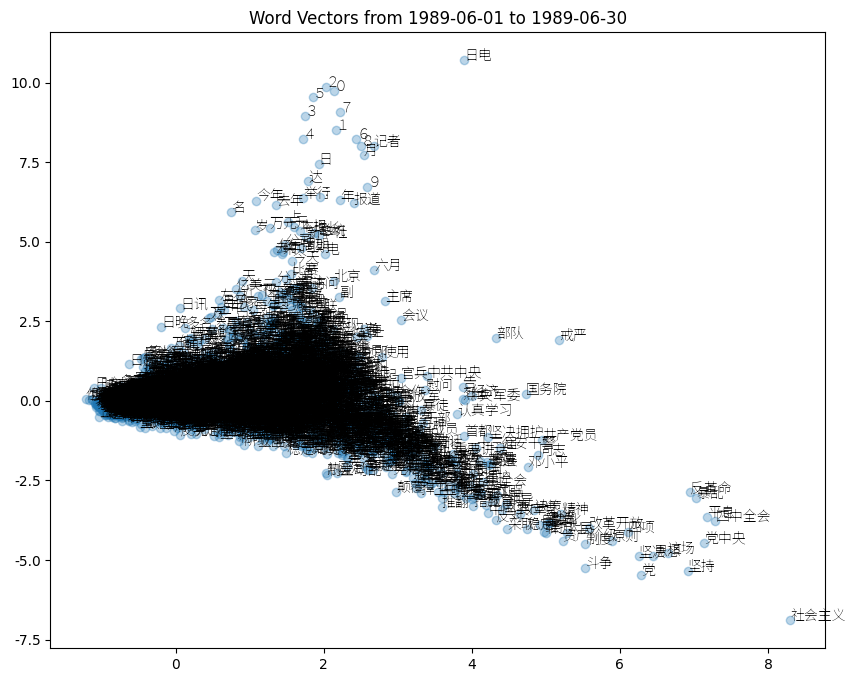

Most similar to 中国:
[('我国', 0.7533654570579529), ('中国政府', 0.6848145127296448), ('亚洲', 0.6391541361808777), ('各国', 0.6005380749702454), ('本国', 0.5876596570014954), ('世界', 0.5746610760688782), ('国家', 0.5691891312599182), ('两国', 0.5674341320991516), ('苏联', 0.5648192167282104), ('中华人民共和国', 0.5602022409439087)]


Most similar to 发展:
[('稳步发展', 0.7066436409950256), ('大力发展', 0.7007449865341187), ('迅猛发展', 0.621514081954956), ('蓬勃发展', 0.6023299694061279), ('繁荣', 0.5911629796028137), ('快速增长', 0.5895079374313354), ('推进', 0.5845634341239929), ('增长', 0.583685040473938), ('推动', 0.5750004649162292), ('建设', 0.5746444463729858)]


Most similar to 问题:
[('关键问题', 0.7312959432601929), ('矛盾', 0.6689217686653137), ('热点问题', 0.6497200727462769), ('分歧', 0.6268713474273682), ('腐败问题', 0.6237623691558838), ('当前', 0.6163177490234375), ('方面', 0.6116704344749451), ('难题', 0.5837318897247314), ('疑难问题', 0.571540355682373), ('课题', 0.5687839388847351)]


Most similar to 工作:
[('管理工作', 0.7082614898681641), ('统战工作', 0.6742770

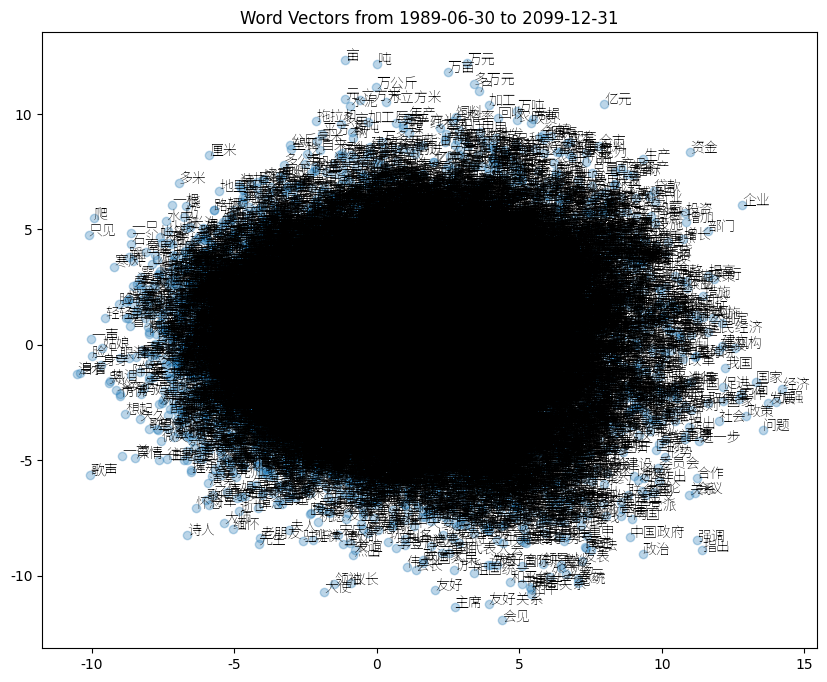

In [ ]:
import gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.font_manager import FontProperties

font_path = 'NotoSansSC-VariableFont_wght.ttf'
font_prop = FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # Ensure the minus sign is displayed correctly

# Convert 'date' to datetime and handle missing or non-string values in 'preprocessed_text'
preprocessed_df['date'] = pd.to_datetime(preprocessed_df['date'])
preprocessed_df.dropna(subset=['preprocessed_text'], inplace=True)
preprocessed_df['tokenized_text'] = preprocessed_df['preprocessed_text'].apply(lambda x: x.split())

# Define your time periods
periods = [
    ("1985-01-01", "1989-06-01"),
    ("1989-06-01", "1989-06-30"),
    ("1989-06-30", "2099-12-31")
]

# Function to train Word2Vec for each period and visualize the results
def train_and_visualize_word2vec(preprocessed_df, start_date, end_date, font_path):
    period_df = preprocessed_df[(preprocessed_df['date'] >= pd.to_datetime(start_date)) &
                                (preprocessed_df['date'] <= pd.to_datetime(end_date))]

    sentences = period_df['tokenized_text'].tolist()

    # Train Word2Vec model
    model = gensim.models.Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

    # Define target words for visualization
    target_words = ['中国','发展', '问题', '工作', '国家', '经济', '企业', '同志','社会主义']

    # Find similar words and words that don't match
    for word in target_words:
        if word in model.wv:
            print(f"Most similar to {word}:")
            print(model.wv.most_similar(word))
            print("\n")

    # Visualize word vectors
    words = sum([[k] for k, v in model.wv.key_to_index.items()], [])
    word_vectors = np.array([model.wv[w] for w in words])

    # Reduce dimensions with PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(word_vectors)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.3)
    for i, word in enumerate(words):
        plt.annotate(word, xy=(pca_result[i, 0], pca_result[i, 1]), fontproperties=font_prop)
    plt.title(f"Word Vectors from {start_date} to {end_date}")
    plt.show()

# Apply the function to each time period
font_path = 'NotoSansSC-Regular.ttf'
for start_date, end_date in periods:
    train_and_visualize_word2vec(preprocessed_df, start_date, end_date, font_path=font_path)


Most similar to 中国:
[('我国', 0.698336660861969), ('中国政府', 0.6468982696533203), ('苏联', 0.603101909160614), ('贵国', 0.5914896130561829), ('各国', 0.5791704654693604), ('巴基斯坦', 0.5739282369613647), ('日本', 0.5684155821800232), ('波兰', 0.564411461353302), ('欧洲', 0.5606083869934082), ('中华人民共和国', 0.5587060451507568)]


Most similar to 发展:
[('大力发展', 0.7576775550842285), ('稳步发展', 0.7137437462806702), ('蓬勃发展', 0.669593334197998), ('发达', 0.6054893732070923), ('迅猛发展', 0.5944808721542358), ('稳定增长', 0.5877625346183777), ('增长', 0.5843358039855957), ('繁荣', 0.5829378962516785), ('发展趋势', 0.5803698897361755), ('振兴', 0.5629289746284485)]


Most similar to 问题:
[('关键问题', 0.7568830251693726), ('矛盾', 0.6699191331863403), ('分歧', 0.6327453851699829), ('当前', 0.6258301734924316), ('难题', 0.600554347038269), ('方面', 0.5763540267944336), ('课题', 0.5745065212249756), ('困难', 0.5717689990997314), ('疑难问题', 0.5679255127906799), ('着重', 0.5674206614494324)]


Most similar to 工作:
[('管理工作', 0.6791381239891052), ('科研工作', 0.664745628

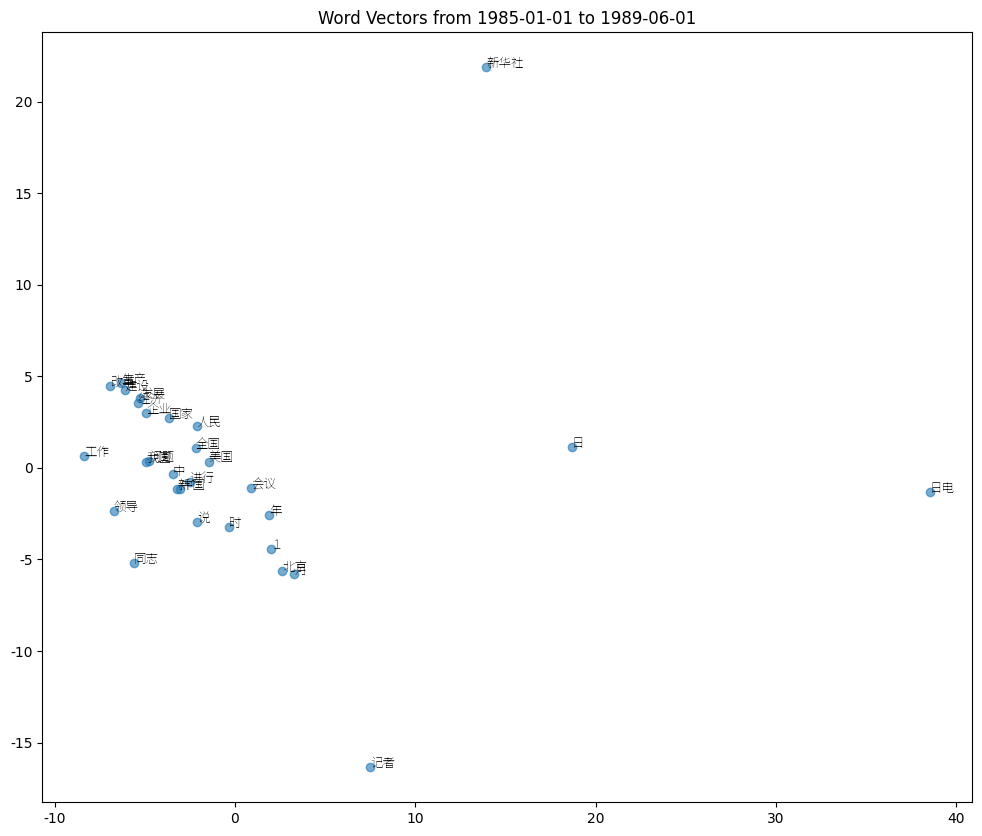

Most similar to 中国:
[('内政', 0.9098953008651733), ('干涉', 0.9058298468589783), ('内部事务', 0.8361232876777649), ('国际商会', 0.8150341510772705), ('东欧国家', 0.8080064654350281), ('外国', 0.8044613599777222), ('日中', 0.8039923906326294), ('关系', 0.7941198348999023), ('朝鲜', 0.7871845960617065), ('西方', 0.7845268249511719)]


Most similar to 发展:
[('步骤', 0.9453168511390686), ('我国', 0.9425820708274841), ('关系', 0.9399163722991943), ('商品经济', 0.9233470559120178), ('社会', 0.9206050634384155), ('历史', 0.9192773103713989), ('文化', 0.9187943339347839), ('友好关系', 0.9153552055358887), ('经济', 0.9137568473815918), ('建立', 0.9109026193618774)]


Most similar to 问题:
[('解决', 0.9558761715888977), ('政府', 0.8954861760139465), ('关系', 0.8884152173995972), ('一致意见', 0.8856181502342224), ('印支', 0.8823186159133911), ('方面', 0.8805950880050659), ('基本方针', 0.8745997548103333), ('和平', 0.8725638389587402), ('学术交流', 0.8679085373878479), ('外来干涉', 0.8644419312477112)]


Most similar to 工作:
[('做好', 0.9338269829750061), ('思想', 0.924946546554565

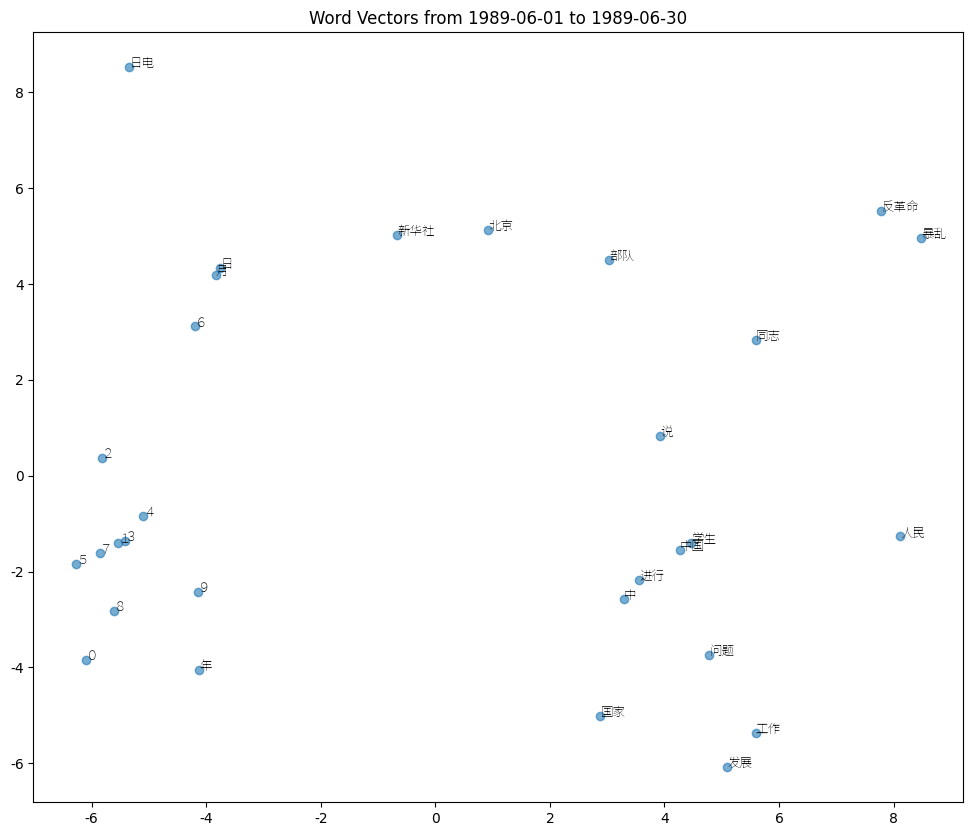

Most similar to 中国:
[('我国', 0.7582517266273499), ('中国政府', 0.6731602549552917), ('亚洲', 0.6474641561508179), ('各国', 0.5859612822532654), ('欧洲', 0.5745890140533447), ('海峡两岸', 0.5730765461921692), ('世界', 0.572830080986023), ('印度', 0.5620884299278259), ('中华人民共和国', 0.5594542622566223), ('苏联', 0.5567253232002258)]


Most similar to 发展:
[('稳步发展', 0.7078068256378174), ('大力发展', 0.7035377025604248), ('迅猛发展', 0.6277219653129578), ('蓬勃发展', 0.6272484064102173), ('超前发展', 0.6215770244598389), ('振兴', 0.599672257900238), ('快速增长', 0.5850979685783386), ('建设', 0.581775963306427), ('推动', 0.5802119970321655), ('推进', 0.5784274339675903)]


Most similar to 问题:
[('关键问题', 0.7639340758323669), ('热点问题', 0.6702101826667786), ('矛盾', 0.6568832993507385), ('分歧', 0.6191542744636536), ('当前', 0.6107336282730103), ('腐败问题', 0.6033501029014587), ('难题', 0.5896749496459961), ('方面', 0.5892748832702637), ('课题', 0.5809590816497803), ('领土问题', 0.5804455876350403)]


Most similar to 工作:
[('管理工作', 0.7209726572036743), ('统战工作', 0.674

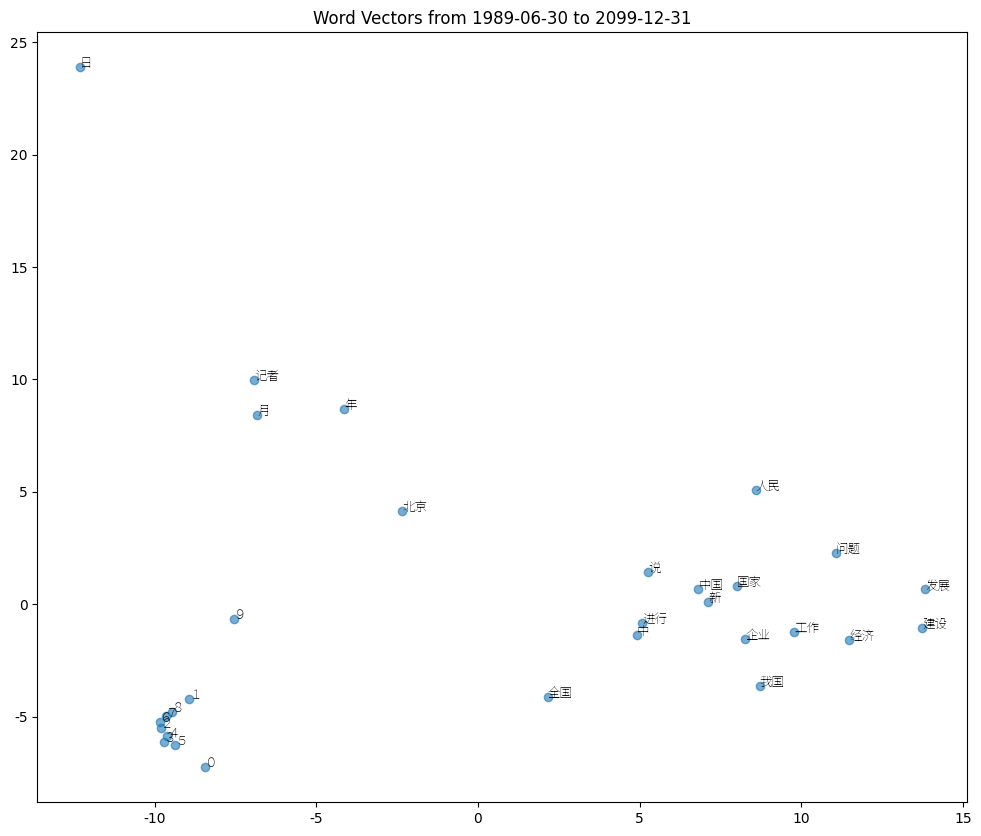

In [ ]:
import gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.font_manager import FontProperties

font_path = 'NotoSansSC-VariableFont_wght.ttf'
font_prop = FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # Ensure the minus sign is displayed correctly

# Convert 'date' to datetime and handle missing or non-string values in 'preprocessed_text'
preprocessed_df['date'] = pd.to_datetime(preprocessed_df['date'])
preprocessed_df.dropna(subset=['preprocessed_text'], inplace=True)
preprocessed_df['tokenized_text'] = preprocessed_df['preprocessed_text'].apply(lambda x: x.split())

# Define your time periods
periods = [
    ("1985-01-01", "1989-06-01"),
    ("1989-06-01", "1989-06-30"),
    ("1989-06-30", "2099-12-31")
]

def train_and_visualize_word2vec(preprocessed_df, start_date, end_date, font_path):
    period_df = preprocessed_df[(preprocessed_df['date'] >= pd.to_datetime(start_date)) &
                                (preprocessed_df['date'] <= pd.to_datetime(end_date))]

    sentences = period_df['tokenized_text'].tolist()

    # Train Word2Vec model
    model = gensim.models.Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

    # Define target words for visualization
    target_words = ['中国','发展', '问题', '工作', '国家', '经济', '企业', '同志','社会主义']

    # Find similar words and words that don't match
    for word in target_words:
        if word in model.wv:
            print(f"Most similar to {word}:")
            print(model.wv.most_similar(word))
            print("\n")

    # Visualize word vectors
    top_words = sorted(model.wv.key_to_index.keys(), key=lambda word: model.wv.get_vecattr(word, "count"), reverse=True)[:30]
    word_vectors = np.array([model.wv[word] for word in top_words])

    # Reduce dimensions with PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(word_vectors)

    # Plot
    plt.figure(figsize=(12, 10))  # Increase figure size for better readability
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
    for i, word in enumerate(top_words):
        plt.annotate(word, xy=(pca_result[i, 0], pca_result[i, 1]), fontproperties=font_prop, fontsize=9)  # Set a smaller font size
    plt.title(f"Word Vectors from {start_date} to {end_date}")
    plt.show()

# Apply the function to each time period
font_path = 'NotoSansSC-Regular.ttf'
for start_date, end_date in periods:
    train_and_visualize_word2vec(preprocessed_df, start_date, end_date, font_path=font_path)

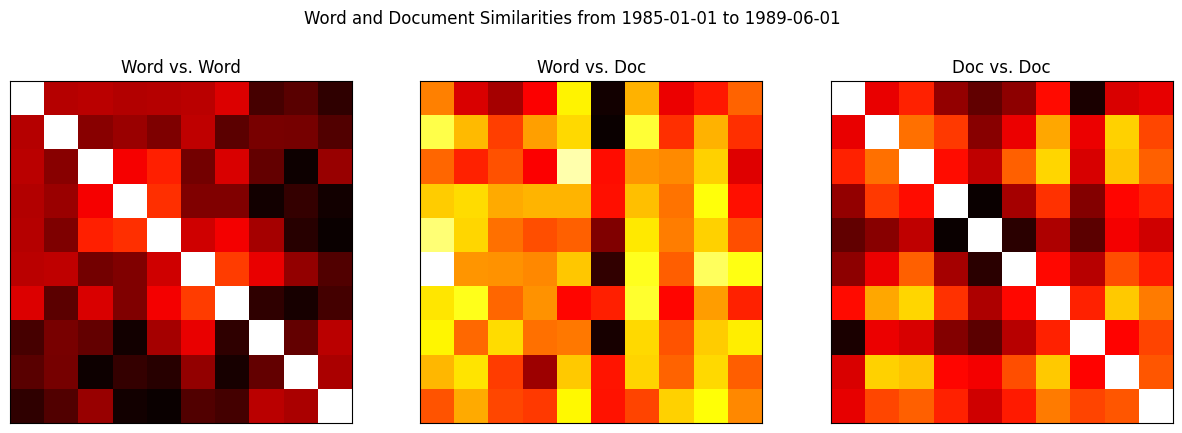

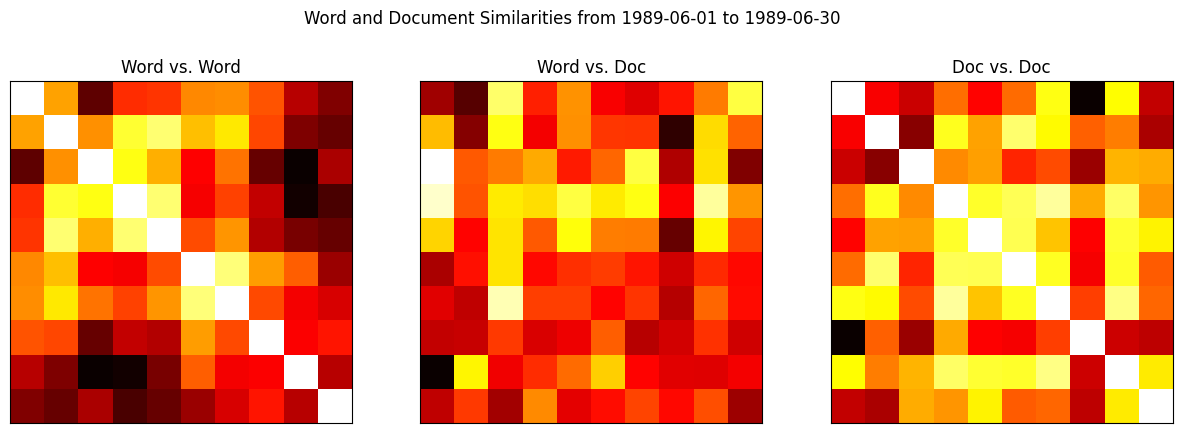

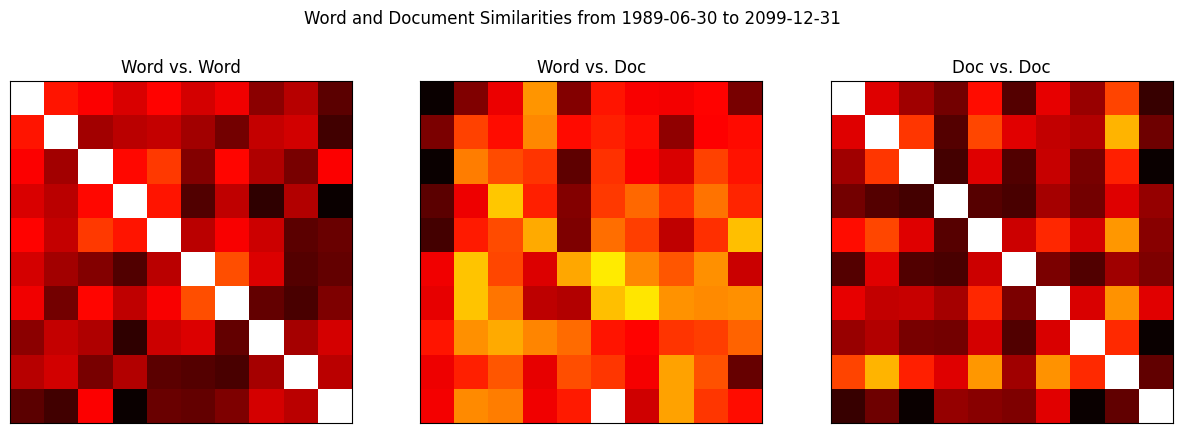

In [ ]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics

# Ensure 'preprocessed_text' is a list of tokens
preprocessed_df['tokenized_text'] = preprocessed_df['preprocessed_text'].apply(lambda x: x.split() if isinstance(x, str) else x)

# Define time periods
periods = [
    ("1985-01-01", "1989-06-01"),
    ("1989-06-01", "1989-06-30"),
    ("1989-06-30", "2099-12-31")
]

# Create TaggedDocument for each period
tagged_documents_periods = {}
for start, end in periods:
    period_df = preprocessed_df[(preprocessed_df['date'] >= start) & (preprocessed_df['date'] <= end)]
    tagged_documents = [TaggedDocument(words=words_list, tags=[index]) for index, words_list in enumerate(period_df['tokenized_text'])]
    tagged_documents_periods[(start, end)] = tagged_documents

# Train Doc2Vec models for each period
models = {}
for period, tagged_docs in tagged_documents_periods.items():
    model = Doc2Vec(tagged_docs, vector_size=100, window=5, min_count=5, workers=4)
    models[period] = model

# Visualization function for words and documents
def visualize_similarities(model, words, document_tags, title):
    word_vectors = np.array([model.wv[word] for word in words if word in model.wv])
    doc_vectors = np.array([model.dv[tag] for tag in document_tags])

    # Normalize vectors for cosine similarity
    word_vectors_norm = sklearn.preprocessing.normalize(word_vectors)
    doc_vectors_norm = sklearn.preprocessing.normalize(doc_vectors)

    # Similarities (word vs word)
    word_similarities = sklearn.metrics.pairwise.cosine_similarity(word_vectors_norm)
    # Similarities (word vs doc)
    word_doc_similarities = sklearn.metrics.pairwise.cosine_similarity(word_vectors_norm, doc_vectors_norm)
    # Similarities (doc vs doc)
    doc_similarities = sklearn.metrics.pairwise.cosine_similarity(doc_vectors_norm)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(word_similarities, cmap='hot', interpolation='nearest')
    axes[0].set_title('Word vs. Word')
    axes[1].imshow(word_doc_similarities, cmap='hot', interpolation='nearest')
    axes[1].set_title('Word vs. Doc')
    axes[2].imshow(doc_similarities, cmap='hot', interpolation='nearest')
    axes[2].set_title('Doc vs. Doc')

    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    plt.suptitle(title)
    plt.show()

# Example usage for each period
for period, model in models.items():
    words = ['中国', '发展', '企业','金融','经济','社会主义','资本主义','人民','同志','学生']  # Example words, replace with words relevant to your analysis
    document_tags = list(range(10))  # Example document tags (indices), adjust as needed
    visualize_similarities(model, words, document_tags, f'Word and Document Similarities from {period[0]} to {period[1]}')


In [ ]:
preprocessed_df.head()

date                             title  \
0 1985-01-01                和衷共济搞四化——一九八五年元旦献词   
1 1985-01-01                     一九八五年一月上旬天气展望   
2 1985-01-01                     血液换出稀释法可治疗脑血栓   
3 1985-01-01  玻利维亚紧张局势得到缓和  拒绝交权的前陆军司令奥尔维斯被迫投降   
4 1985-01-01                     北京假肢科研所主体工程奠基   

                                                text  \
0      和衷共济搞四化\n    ——一九八五年元旦献词\n    岁月之树又增添了一周新的...   
1      一九八五年一月上旬天气展望\n    据新华社北京12月31日电　中央气象台对198...   
2      血液换出稀释法可治疗脑血栓\n    山东省济宁市第二人民医院用血液换出稀释法治疗脑...   
3      玻利维亚紧张局势得到缓和\n    拒绝交权的前陆军司令奥尔维斯被迫投降\n    ...   
4      北京假肢科研所主体工程奠基\n    本报讯  民政部北京假肢科研主体工程12月31...   

                                   preprocessed_text  \
0          和衷共济 搞 四化 \n         一九八五年 元旦 献词 \n   ...   
1          一九八五年 一月 上旬 天气 展望 \n         新华社 北京 12...   
2          血液 换 出 稀释 法可 治疗 脑血栓 \n         山东省 济宁市...   
3          玻利维亚 紧张局势 得到 缓和 \n         拒绝 交权 前 陆军 ...   
4          北京 假肢 科研所 主体工程 奠基 \n         本报讯     民...   

                                        title_tokens  \
0  ['和衷共济', '搞', '四化', '—', '—', '一九八五年', '元旦', '...   
1                  ['一九八五年', '一月', '上旬', '天气', '展望']   
2          ['血液', '换', '出', '稀释', '法可', '治疗', '脑血栓']   
3  ['玻利维亚', '紧张局势', '得到', '缓和', ' ', ' ', '拒绝', '...   
4                  ['北京', '假肢', '科研所', '主体工程', '奠基']   

                                      tokenized_text  
0  [和衷共济, 搞, 四化, 一九八五年, 元旦, 献词, 岁月, 之树, 增添, 一周, 新...  
1  [一九八五年, 一月, 上旬, 天气, 展望, 新华社, 北京, 12, 月, 31, 日电...  
2  [血液, 换, 出, 稀释, 法可, 治疗, 脑血栓, 山东省, 济宁市, 人民, 医院, ...  
3  [玻利维亚, 紧张局势, 得到, 缓和, 拒绝, 交权, 前, 陆军, 司令, 奥尔, 维斯...  
4  [北京, 假肢, 科研所, 主体工程, 奠基, 本报讯, 民政部, 北京, 假肢, 科研, ...